In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
#which X?? max could do overfitting


In [5]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [7]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [40]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [8]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [9]:
#generate conf matrix...
confe_matrix = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix[t,:,:] = confe_matrix[t,:,:]/confe_matrix[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

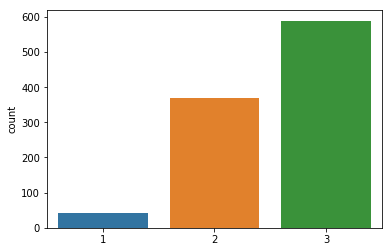

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


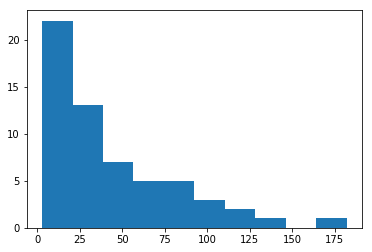

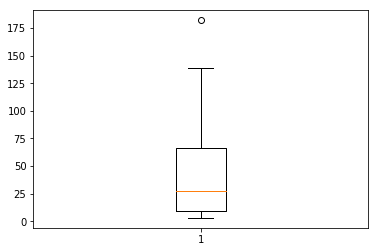

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

#### Delta Convergence criteria

In [10]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [20]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Trained IDeal Model, Epochs to converge = 6


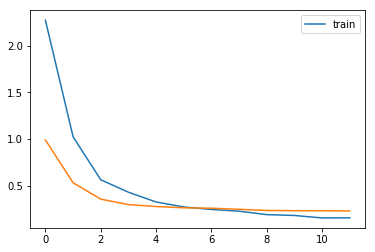

In [42]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [14]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.614331819028
2 	 -2762.646205813235 	0.0214	0.065072	0.026419
3 	 -2736.6331912176543 	0.0117	0.059334	0.009416
4 	 -2725.378102461501 	0.0071	0.058779	0.004113
5 	 -2719.697361647746 	0.0041	0.051646	0.002084
6 	 -2716.566652090635 	0.0027	0.040519	0.001151
7 	 -2714.7759730273488 	0.0021	0.031279	0.000659
8 	 -2713.6296358271984 	0.0017	0.024918	0.000422
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]


In [46]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [24]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [106]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Trained model over soft-MV, Epochs to converge = 7


In [107]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

Trained model over hard-MV, Epochs to converge = 13


In [22]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

Trained model over D&S, Epochs to converge = 7


### Raykar Model (joint predict model)

In [11]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [10]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 2.03 sec)	logL: -3050.267	
Iter 2/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -2642.405	Tol1: 0.13371	Tol2: 0.11462	
Iter 3/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -2496.312	Tol1: 0.05529	Tol2: 0.03931	
Iter 4/50 
M step: done,  E step: done //  (in 0.09 sec)	logL: -2418.961	Tol1: 0.03099	Tol2: 0.03050	
Iter 5/50 
M step: done,  E step: done //  (in 0.09 sec)	logL: -2368.606	Tol1: 0.02082	Tol2: 0.02815	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.00 sec)	logL: -3101.287	
Iter 2/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -2632.131	Tol1: 0.15128	Tol2: 0.08797	
Iter 3/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -2460.404	Tol1: 0.06524	Tol2: 0.04151	
Iter 4/50 
M step: done,  E 

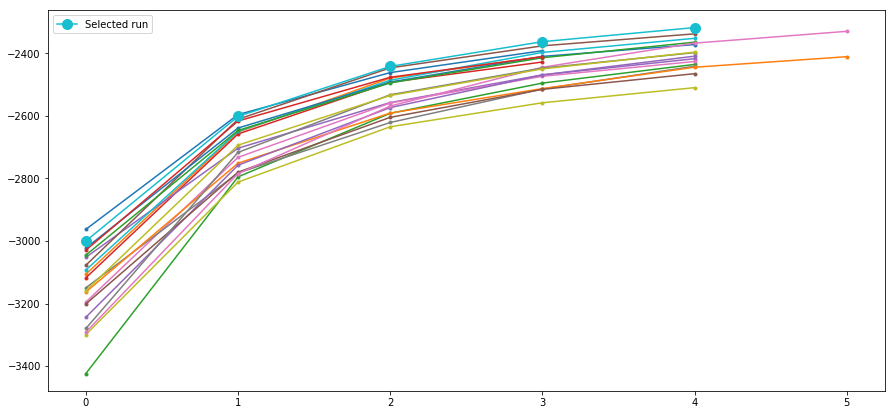

In [67]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [12]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


In [320]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


In [13]:
for _ in range(100):
    gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
    gMixture_Global.lambda_random = True 
    logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,cluster=True)
    #del gMixture_Global
    gc.collect()
    keras.backend.clear_session()

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003717 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45485008 0.12808715 0.38481548]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.63 sec)	logL: -3199.627	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  1.0


TypeError: set_session() missing 1 required positional argument: 'session'

In [16]:
keras.backend.clear_session()

In [10]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(5,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,cluster=True)


Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004621 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.87675107 0.30379006 0.36473882]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.71 sec)	logL: -2991.644	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25412965 0.41016626 0.76764065]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.56 sec)	logL: -3050.570	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16542503 0.934696   0.9941897 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.67 sec)	logL: -3324.123	
Finished training!
Initializing new EM...
P

In [14]:
gMixture_Global.base_model.losses

[]

In [17]:
gMixture_Global.base_model.predict(Xstd_train)

NotFoundError: FeedInputs: unable to find feed output input_1:0

In [28]:

it = keras.layers.Input(shape=Xstd_train.shape[1:])
aux = keras.models.clone_model( gMixture_Global.base_model,input_tensors=it)
aux.compile(loss='mse',optimizer='adam')
aux.fit(Xstd_train,r_obs)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x2aac6dc8fc88>>
Traceback (most recent call last):
  File "/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1464, in __del__
    self._session._session, self._handle, status)
  File "/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 93825078371664


Epoch 1/1
1000/1000 [==============================] - 0s 235us/step - loss: 0.5781


In [25]:
aux.predict(Xstd_train)

array([[5.95938765e-09, 2.41541164e-03, 6.80645881e-03, ...,
        4.80221462e-12, 1.45825629e-09, 1.26161486e-11],
       [5.66621403e-13, 6.54334471e-08, 9.99946833e-01, ...,
        1.56728285e-14, 2.83844562e-12, 4.21268983e-18],
       [9.24570109e-09, 3.21129164e-07, 9.99889612e-01, ...,
        9.62654045e-09, 2.43776549e-06, 6.87259094e-09],
       ...,
       [1.05926556e-04, 3.64854746e-02, 2.62066405e-02, ...,
        2.17427427e-04, 9.40517475e-06, 8.08075038e-06],
       [1.76586254e-05, 1.49119832e-03, 9.78813946e-01, ...,
        2.09218240e-04, 4.99522175e-05, 2.23705210e-05],
       [3.16054544e-10, 6.83216513e-06, 6.45578257e-06, ...,
        8.56820121e-03, 2.40488895e-04, 1.15484099e-05]], dtype=float32)

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(2,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Wmean JS"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004658 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0091215 0.6219893]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3564.028	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2201.859	Tol1: 0.38220	Tol2: 0.95869	Tol3: 0.49993	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1884.407	Tol1: 0.14417	Tol2: 0.20752	Tol3: 0.06585	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1756.566	Tol1: 0.06784	Tol2: 0.15221	Tol3: 0.14541	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1700.558	Tol1: 0.03188	Tol2: 0.08429	Tol3: 0.19216	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1654.501	Tol1: 0.02708	Tol2: 0.05270	Tol3: 0.21178	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5356109 0.5179755]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3868.809	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2473.638	Tol1: 0.36062	Tol2: 0.66524	Tol3: 0.11081	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2209.356	Tol1: 0.10684	Tol2: 0.17421	Tol3: 0.18443	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2104.941	Tol1: 0.04726	Tol2: 0.11517	Tol3: 0.19241	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2021.882	Tol1: 0.03946	Tol2: 0.08400	Tol3: 0.19706	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1946.990	Tol1: 0.03704	Tol2: 0.04855	Tol3: 0.20977	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.159	Tol1: 0.02868	Tol2: 0.03808	Tol3: 0.21870	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1851.248	Tol1:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.534	Tol1: 0.02846	Tol2: 0.02993	Tol3: 0.25338	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51297605 0.8223143 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3402.604	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2339.232	Tol1: 0.31252	Tol2: 0.38369	Tol3: 0.12143	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2055.310	Tol1: 0.12137	Tol2: 0.14816	Tol3: 0.19318	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1928.697	Tol1: 0.06160	Tol2: 0.10097	Tol3: 0.21626	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.566	Tol1: 0.05192	Tol2: 0.06270	Tol3: 0.23092	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1749.327	Tol1: 0.04333	Tol2: 0.04208	Tol3: 0.24298	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.562	Tol1: 0.02174	Tol2: 0.03870	Tol3: 0.24029	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1633.705	Tol1: 0.01913	Tol2: 0.02453	Tol3: 0.24433	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78851324 0.0460243 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2900.618	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2137.264	Tol1: 0.26317	Tol2: 0.32995	Tol3: 0.06323	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1930.741	Tol1: 0.09663	Tol2: 0.12681	Tol3: 0.19003	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1813.309	Tol1: 0.06082	Tol2: 0.07498	Tol3: 0.21276	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1752.278	Tol1: 0.03366	Tol2: 0.05202	Tol3: 0.22619	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.403	Tol1: 0.03927	Tol2: 0.06241	Tol3: 0.22872	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.138	Tol1: 0.02308	Tol2: 0.03858	Tol3: 0.23634	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1625.725	Tol1: 0.02191	Tol2: 0.02330	Tol3: 0.23981	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9216456  0.19058685]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2910.467	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2158.005	Tol1: 0.25854	Tol2: 0.29217	Tol3: 0.09273	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.308	Tol1: 0.09115	Tol2: 0.12892	Tol3: 0.20467	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.978	Tol1: 0.05064	Tol2: 0.06832	Tol3: 0.20851	
Iter 5/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.446	Tol1: 0.03906	Tol2: 0.02139	Tol3: 0.25071	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1596.468	Tol1: 0.03271	Tol2: 0.02289	Tol3: 0.24763	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1553.377	Tol1: 0.02699	Tol2: 0.02224	Tol3: 0.24904	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.55
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003562 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40090644 0.2603973 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -3357.525	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2336.083	Tol1: 0.30422	Tol2: 0.63277	Tol3: 0.34194	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2065.236	Tol1:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1872.751	Tol1: 0.04747	Tol2: 0.08224	Tol3: 0.20708	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1803.298	Tol1: 0.03709	Tol2: 0.05958	Tol3: 0.22229	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1735.059	Tol1: 0.03784	Tol2: 0.03773	Tol3: 0.23825	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.662	Tol1: 0.03423	Tol2: 0.03463	Tol3: 0.25061	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.444	Tol1: 0.02698	Tol2: 0.02986	Tol3: 0.25662	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15535583 0.0272579 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2828.451	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1984.474	Tol1: 0.29839	Tol2: 0.50800	Tol3: 0.06855	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.188	Tol1: 0.03232	Tol2: 0.05185	Tol3: 0.21997	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.793	Tol1: 0.02913	Tol2: 0.04270	Tol3: 0.23162	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.702	Tol1: 0.01915	Tol2: 0.03474	Tol3: 0.23860	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1721.468	Tol1: 0.01388	Tol2: 0.02044	Tol3: 0.23812	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23223688 0.99860466]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3140.538	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2127.155	Tol1: 0.32268	Tol2: 0.49793	Tol3: 0.10083	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1957.091	Tol1: 0.07995	Tol2: 0.14941	Tol3: 0.15349	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.950	Tol1: 0.05099	Tol2: 0.10293	Tol3: 0.18657	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.990	Tol1: 0.04111	Tol2: 0.07428	Tol3: 0.20443	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.969	Tol1: 0.02494	Tol2: 0.04710	Tol3: 0.21840	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.199	Tol1: 0.01948	Tol2: 0.02969	Tol3: 0.22982	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1403186  0.97429234]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2980.356	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2134.544	Tol1: 0.28380	Tol2: 0.53503	Tol3: 0.17298	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.263	Tol1: 0.10367	Tol2: 0.14529	Tol3: 0.12946	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -2093.535	Tol1: 0.10963	Tol2: 0.12632	Tol3: 0.16805	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1960.956	Tol1: 0.06333	Tol2: 0.09447	Tol3: 0.20875	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.402	Tol1: 0.04414	Tol2: 0.06454	Tol3: 0.22261	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1809.606	Tol1: 0.03457	Tol2: 0.05208	Tol3: 0.23462	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1755.120	Tol1: 0.03011	Tol2: 0.02597	Tol3: 0.23750	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.682	Tol1: 0.02817	Tol2: 0.02587	Tol3: 0.24233	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.562004  0.7989997]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2941.883	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.50 sec)	logL: -3003.279	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2180.778	Tol1: 0.27387	Tol2: 0.30094	Tol3: 0.09644	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1953.235	Tol1: 0.10434	Tol2: 0.11833	Tol3: 0.21420	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1847.272	Tol1: 0.05425	Tol2: 0.07745	Tol3: 0.22710	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.344	Tol1: 0.04110	Tol2: 0.05219	Tol3: 0.23729	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1708.978	Tol1: 0.03521	Tol2: 0.03403	Tol3: 0.24484	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.212	Tol1: 0.02736	Tol2: 0.02928	Tol3: 0.25069	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.6
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003428 mins
Initializing new EM...
Pre-train n

M step: done,  E step: done //  (in 0.51 sec)	logL: -3182.200	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -2059.272	Tol1: 0.35288	Tol2: 0.33572	Tol3: 0.05490	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.422	Tol1: 0.10967	Tol2: 0.14512	Tol3: 0.21818	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.805	Tol1: 0.05161	Tol2: 0.09229	Tol3: 0.21590	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1684.824	Tol1: 0.03105	Tol2: 0.05847	Tol3: 0.22375	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1653.164	Tol1: 0.01879	Tol2: 0.03590	Tol3: 0.23412	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1622.838	Tol1: 0.01834	Tol2: 0.01774	Tol3: 0.24260	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73209995 0.26502717]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -2131.635	Tol1: 0.32602	Tol2: 0.30852	Tol3: 0.02640	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1921.538	Tol1: 0.09856	Tol2: 0.12522	Tol3: 0.21020	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.194	Tol1: 0.04858	Tol2: 0.07135	Tol3: 0.20977	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.595	Tol1: 0.03205	Tol2: 0.05265	Tol3: 0.21751	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.608	Tol1: 0.02825	Tol2: 0.03904	Tol3: 0.22513	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.119	Tol1: 0.02238	Tol2: 0.02409	Tol3: 0.23129	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97901064 0.8321148 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2738.375	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -2099.363	Tol1: 0.26888	Tol2: 0.30791	Tol3: 0.08007	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.420	Tol1: 0.10096	Tol2: 0.11299	Tol3: 0.20348	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1773.139	Tol1: 0.06055	Tol2: 0.07961	Tol3: 0.21065	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.491	Tol1: 0.03702	Tol2: 0.05078	Tol3: 0.22070	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.794	Tol1: 0.02735	Tol2: 0.02994	Tol3: 0.22666	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.91566235 0.5909912 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2786.757	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2086.001	Tol1: 0.25146	Tol2: 0.29060	Tol3: 0.09991	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.412	Tol1: 0.04274	Tol2: 0.02983	Tol3: 0.24329	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.798	Tol1: 0.02807	Tol2: 0.02916	Tol3: 0.24781	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8154009  0.05091608]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2603.083	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2001.928	Tol1: 0.23094	Tol2: 0.26717	Tol3: 0.14683	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1849.034	Tol1: 0.07637	Tol2: 0.12164	Tol3: 0.21893	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.917	Tol1: 0.04549	Tol2: 0.06726	Tol3: 0.23293	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.481	Tol1: 0.03254	Tol2: 0.03994	Tol3: 0.24904	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.904	Tol1: 0.04183	Tol2: 0.04928	Tol3: 0.24478	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.921	Tol1: 0.03147	Tol2: 0.03935	Tol3: 0.25678	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.727	Tol1: 0.02435	Tol2: 0.02415	Tol3: 0.26248	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.3
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003505 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21649925 0.43417045]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3481.321	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2238.882	Tol1: 0.35689	Tol2: 0.82283	Tol3: 0.39201	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1996.314	Tol1: 0

M step: done,  E step: done //  (in 0.58 sec)	logL: -2900.372	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2135.469	Tol1: 0.26373	Tol2: 0.34240	Tol3: 0.04136	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1949.305	Tol1: 0.08718	Tol2: 0.11581	Tol3: 0.20636	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.916	Tol1: 0.04945	Tol2: 0.07538	Tol3: 0.21991	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1775.840	Tol1: 0.04160	Tol2: 0.04979	Tol3: 0.23301	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -1718.305	Tol1: 0.03240	Tol2: 0.03610	Tol3: 0.24735	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1668.556	Tol1: 0.02895	Tol2: 0.02241	Tol3: 0.25165	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9267052  0.71927035]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1777.354	Tol1: 0.05406	Tol2: 0.08056	Tol3: 0.20824	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.478	Tol1: 0.02694	Tol2: 0.06125	Tol3: 0.22276	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.869	Tol1: 0.02290	Tol2: 0.04347	Tol3: 0.23743	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.815	Tol1: 0.02074	Tol2: 0.02563	Tol3: 0.24976	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14432688 0.5461325 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3592.470	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2232.876	Tol1: 0.37846	Tol2: 0.72266	Tol3: 0.28357	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1962.306	Tol1: 0.12118	Tol2: 0.16104	Tol3: 0.17864	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -1737.744	Tol1: 0.06264	Tol2: 0.12862	Tol3: 0.17741	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1679.952	Tol1: 0.03326	Tol2: 0.06547	Tol3: 0.21190	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1645.400	Tol1: 0.02057	Tol2: 0.03711	Tol3: 0.23062	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1613.885	Tol1: 0.01915	Tol2: 0.03310	Tol3: 0.24177	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.675	Tol1: 0.02306	Tol2: 0.02307	Tol3: 0.25121	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37354833 0.2648777 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3536.054	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2201.135	Tol1: 0.37752	Tol2: 0.43017	Tol3: 0.06219	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.09 sec)	logL: -1788.354	Tol1: 0.03799	Tol2: 0.07772	Tol3: 0.23500	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1732.691	Tol1: 0.03112	Tol2: 0.05827	Tol3: 0.23518	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.932	Tol1: 0.03276	Tol2: 0.03559	Tol3: 0.24310	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1639.208	Tol1: 0.02191	Tol2: 0.02689	Tol3: 0.25211	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.67985946 0.88984054]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2928.055	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2096.133	Tol1: 0.28412	Tol2: 0.33367	Tol3: 0.04880	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1867.866	Tol1: 0.10890	Tol2: 0.13370	Tol3: 0.21435	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.452	Tol1: 0.02344	Tol2: 0.02162	Tol3: 0.22021	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.3
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003766 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05750681 0.94500494]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3269.299	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2147.169	Tol1: 0.34323	Tol2: 0.55338	Tol3: 0.13174	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1888.311	Tol1: 0.12056	Tol2: 0.16125	Tol3: 0.14418	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.335	Tol1: 0.06724	Tol2: 0.10276	Tol3: 0.18158	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.648	Tol1: 0

M step: done,  E step: done //  (in 0.05 sec)	logL: -2214.945	Tol1: 0.13482	Tol2: 0.17571	Tol3: 0.11058	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2058.973	Tol1: 0.07042	Tol2: 0.11446	Tol3: 0.20050	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.010	Tol1: 0.05486	Tol2: 0.07641	Tol3: 0.21929	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1866.773	Tol1: 0.04072	Tol2: 0.05260	Tol3: 0.23261	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1795.273	Tol1: 0.03830	Tol2: 0.03819	Tol3: 0.23746	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1739.144	Tol1: 0.03126	Tol2: 0.02670	Tol3: 0.23782	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.751	Tol1: 0.03070	Tol2: 0.02804	Tol3: 0.23544	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1649.208	Tol1: 0.02168	Tol2: 0.02283	Tol3: 0.23839	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.74672484 0.02053793]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2983.432	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2201.715	Tol1: 0.26202	Tol2: 0.37974	Tol3: 0.02303	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1991.623	Tol1: 0.09542	Tol2: 0.13290	Tol3: 0.19069	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.319	Tol1: 0.06241	Tol2: 0.09607	Tol3: 0.20865	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.124	Tol1: 0.03920	Tol2: 0.06555	Tol3: 0.21955	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.272	Tol1: 0.02667	Tol2: 0.04216	Tol3: 0.23480	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.720	Tol1: 0.02895	Tol2: 0.03257	Tol3: 0.24095	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.014	Tol

M step: done,  E step: done //  (in 0.07 sec)	logL: -1836.841	Tol1: 0.04263	Tol2: 0.02977	Tol3: 0.23274	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1759.431	Tol1: 0.04214	Tol2: 0.02785	Tol3: 0.24075	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1697.444	Tol1: 0.03523	Tol2: 0.02558	Tol3: 0.24463	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1653.809	Tol1: 0.02571	Tol2: 0.02670	Tol3: 0.24413	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6906638  0.35500997]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3694.498	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2341.686	Tol1: 0.36617	Tol2: 0.48360	Tol3: 0.10392	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1984.142	Tol1: 0.15269	Tol2: 0.14410	Tol3: 0.19904	
Iter 4/50
M step: done,  E step: done //  

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23830718 0.869593  ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3422.032	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2229.292	Tol1: 0.34855	Tol2: 0.66365	Tol3: 0.32229	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1967.328	Tol1: 0.11751	Tol2: 0.18352	Tol3: 0.16700	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1847.318	Tol1: 0.06100	Tol2: 0.10051	Tol3: 0.19446	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1776.511	Tol1: 0.03833	Tol2: 0.06930	Tol3: 0.21805	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.010	Tol1: 0.03349	Tol2: 0.04438	Tol3: 0.23588	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1670.203	Tol1: 0.02726	Tol2: 0.03393	Tol3: 0.24980	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1630.357	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.616	Tol1: 0.02680	Tol2: 0.05527	Tol3: 0.21775	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.106	Tol1: 0.03011	Tol2: 0.03497	Tol3: 0.22857	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.140	Tol1: 0.01987	Tol2: 0.02935	Tol3: 0.23596	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7784542 0.5529778]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3260.141	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2295.226	Tol1: 0.29597	Tol2: 0.40943	Tol3: 0.00316	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2014.161	Tol1: 0.12246	Tol2: 0.15366	Tol3: 0.21164	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1888.251	Tol1: 0.06251	Tol2: 0.09508	Tol3: 0.22346	
Iter 5/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.55 sec)	logL: -3741.286	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2289.112	Tol1: 0.38815	Tol2: 0.68152	Tol3: 0.48280	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2029.668	Tol1: 0.11334	Tol2: 0.15511	Tol3: 0.20357	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1886.544	Tol1: 0.07052	Tol2: 0.11583	Tol3: 0.23595	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.854	Tol1: 0.04754	Tol2: 0.08036	Tol3: 0.25640	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.068	Tol1: 0.04162	Tol2: 0.05806	Tol3: 0.28326	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1673.924	Tol1: 0.02796	Tol2: 0.04717	Tol3: 0.30162	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.712	Tol1: 0.01745	Tol2: 0.03621	Tol3: 0.31077	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1616.094	Tol1: 0.01740	Tol2: 0.02392	Tol3: 0.31733	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.733	Tol1: 0.03353	Tol2: 0.03815	Tol3: 0.30475	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.461	Tol1: 0.01756	Tol2: 0.03124	Tol3: 0.31301	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.414	Tol1: 0.01833	Tol2: 0.02157	Tol3: 0.31468	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.94509804 0.21497642 0.21182461]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3169.730	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2123.239	Tol1: 0.33015	Tol2: 0.36472	Tol3: 0.03882	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1915.891	Tol1: 0.09766	Tol2: 0.15138	Tol3: 0.28076	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.963	Tol1: 0.05633	Tol2: 0.08133	Tol3: 0.28374	
Iter 5/50
M step: done,  E step:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9188228 0.5621505 0.5114062]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2891.103	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2164.653	Tol1: 0.25127	Tol2: 0.39913	Tol3: 0.04612	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1965.467	Tol1: 0.09202	Tol2: 0.14140	Tol3: 0.24779	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.776	Tol1: 0.05530	Tol2: 0.10121	Tol3: 0.28060	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.375	Tol1: 0.03415	Tol2: 0.05834	Tol3: 0.30145	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.829	Tol1: 0.02484	Tol2: 0.03855	Tol3: 0.31566	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.600	Tol1: 0.02129	Tol2: 0.02416	Tol3: 0.32156	
Finished training!
Initializing new EM...
Pre-train network on 0 ep

M step: done,  E step: done //  (in 0.61 sec)	logL: -3145.687	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2152.286	Tol1: 0.31580	Tol2: 0.32607	Tol3: 0.07645	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1865.857	Tol1: 0.13308	Tol2: 0.13504	Tol3: 0.23506	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1758.831	Tol1: 0.05736	Tol2: 0.09904	Tol3: 0.28626	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1692.135	Tol1: 0.03792	Tol2: 0.07067	Tol3: 0.29763	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.808	Tol1: 0.02206	Tol2: 0.04128	Tol3: 0.30868	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1617.617	Tol1: 0.02247	Tol2: 0.02706	Tol3: 0.31835	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6089132  0.56533617 0.11455119]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.62 sec)	logL: -2620.318	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1963.266	Tol1: 0.25075	Tol2: 0.32250	Tol3: 0.12761	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1818.671	Tol1: 0.07365	Tol2: 0.12847	Tol3: 0.24801	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.590	Tol1: 0.03963	Tol2: 0.06850	Tol3: 0.26578	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1690.758	Tol1: 0.03197	Tol2: 0.05048	Tol3: 0.28405	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.234	Tol1: 0.02101	Tol2: 0.03272	Tol3: 0.30482	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.445	Tol1: 0.02041	Tol2: 0.02020	Tol3: 0.31511	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5846285  0.69232666 0.07859411]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1695.256	Tol1: 0.03160	Tol2: 0.02631	Tol3: 0.31454	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.099	Tol1: 0.02369	Tol2: 0.02044	Tol3: 0.31848	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22437437 0.3746842  0.15690355]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3531.697	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2180.232	Tol1: 0.38267	Tol2: 0.53802	Tol3: 0.24340	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1871.986	Tol1: 0.14138	Tol2: 0.18736	Tol3: 0.23710	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1760.877	Tol1: 0.05935	Tol2: 0.12187	Tol3: 0.24759	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.759	Tol1: 0.03301	Tol2: 0.07428	Tol3: 0.27956	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1735.172	Tol1: 0.04199	Tol2: 0.05917	Tol3: 0.26231	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1689.423	Tol1: 0.02637	Tol2: 0.04303	Tol3: 0.29460	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.965	Tol1: 0.02454	Tol2: 0.03201	Tol3: 0.31251	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.310	Tol1: 0.02406	Tol2: 0.02678	Tol3: 0.32812	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16489843 0.54474556 0.38301957]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3315.269	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2134.858	Tol1: 0.35605	Tol2: 0.50269	Tol3: 0.13365	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1889.194	Tol1: 0.11507	Tol2: 0.15735	Tol3: 0.20474	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.576	Tol1: 0.03858	Tol2: 0.05591	Tol3: 0.30457	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.675	Tol1: 0.03344	Tol2: 0.03730	Tol3: 0.31772	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.258	Tol1: 0.02256	Tol2: 0.02778	Tol3: 0.33174	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.55
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004418 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5605846  0.12412357 0.89356536]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2838.088	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2099.182	Tol1: 0.26035	Tol2: 0.40042	Tol3: 0.01389	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1903

M step: done,  E step: done //  (in 0.06 sec)	logL: -1965.334	Tol1: 0.11544	Tol2: 0.14055	Tol3: 0.19974	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1856.522	Tol1: 0.05537	Tol2: 0.11296	Tol3: 0.24159	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.950	Tol1: 0.03801	Tol2: 0.06930	Tol3: 0.25186	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.318	Tol1: 0.04123	Tol2: 0.04958	Tol3: 0.26922	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.130	Tol1: 0.03398	Tol2: 0.03944	Tol3: 0.28747	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.097	Tol1: 0.01997	Tol2: 0.02937	Tol3: 0.30422	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9514719  0.533146   0.19775438]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2756.655	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1527.470	Tol1: 0.01669	Tol2: 0.02436	Tol3: 0.31683	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1348664  0.21383703 0.02393817]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3772.805	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2387.965	Tol1: 0.36706	Tol2: 0.74200	Tol3: 0.39874	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2014.245	Tol1: 0.15650	Tol2: 0.16660	Tol3: 0.20230	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1858.509	Tol1: 0.07732	Tol2: 0.13805	Tol3: 0.27327	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1778.349	Tol1: 0.04313	Tol2: 0.09347	Tol3: 0.29112	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.831	Tol1: 0.04190	Tol2: 0.06624	Tol3: 0.30856	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1956.857	Tol1: 0.11123	Tol2: 0.14246	Tol3: 0.23373	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1850.372	Tol1: 0.05442	Tol2: 0.09079	Tol3: 0.27377	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.402	Tol1: 0.03673	Tol2: 0.05871	Tol3: 0.29764	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.279	Tol1: 0.02251	Tol2: 0.04139	Tol3: 0.31748	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.634	Tol1: 0.02562	Tol2: 0.02803	Tol3: 0.32345	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35266688 0.981205   0.11942922]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3143.693	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2142.416	Tol1: 0.31850	Tol2: 0.42472	Tol3: 0.01877	
Iter 3/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.49 sec)	logL: -2788.107	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2039.327	Tol1: 0.26856	Tol2: 0.30442	Tol3: 0.16627	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.334	Tol1: 0.08140	Tol2: 0.12173	Tol3: 0.27257	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.830	Tol1: 0.04404	Tol2: 0.07560	Tol3: 0.27783	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.988	Tol1: 0.03453	Tol2: 0.04793	Tol3: 0.28543	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.175	Tol1: 0.02187	Tol2: 0.03256	Tol3: 0.30543	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.718	Tol1: 0.02156	Tol2: 0.02121	Tol3: 0.31954	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33323613 0.06413035 0.52846605]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.296	Tol1: 0.02583	Tol2: 0.04407	Tol3: 0.29915	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1671.388	Tol1: 0.02389	Tol2: 0.03030	Tol3: 0.31747	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.713	Tol1: 0.02374	Tol2: 0.02255	Tol3: 0.33525	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6324817  0.25787812 0.8817039 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3104.804	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2181.274	Tol1: 0.29745	Tol2: 0.33912	Tol3: 0.06800	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1963.215	Tol1: 0.09997	Tol2: 0.12626	Tol3: 0.23533	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1862.032	Tol1: 0.05154	Tol2: 0.09082	Tol3: 0.25779	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -2251.003	Tol1: 0.36468	Tol2: 0.77111	Tol3: 0.57980	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1980.344	Tol1: 0.12024	Tol2: 0.16984	Tol3: 0.12826	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1866.766	Tol1: 0.05735	Tol2: 0.13153	Tol3: 0.20439	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1794.329	Tol1: 0.03880	Tol2: 0.08386	Tol3: 0.23585	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1736.542	Tol1: 0.03221	Tol2: 0.06678	Tol3: 0.25654	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.481	Tol1: 0.02480	Tol2: 0.05847	Tol3: 0.28167	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.843	Tol1: 0.02813	Tol2: 0.03995	Tol3: 0.29801	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.837	Tol1: 0.02309	Tol2: 0.02547	Tol3: 0.30920	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.345	Tol1: 0.06122	Tol2: 0.08501	Tol3: 0.29437	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.744	Tol1: 0.04110	Tol2: 0.05421	Tol3: 0.32236	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.762	Tol1: 0.03004	Tol2: 0.03694	Tol3: 0.33593	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.466	Tol1: 0.03408	Tol2: 0.02112	Tol3: 0.34376	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1606.953	Tol1: 0.02754	Tol2: 0.01756	Tol3: 0.34720	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51147825 0.37611482 0.46183023]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2871.802	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2174.531	Tol1: 0.24280	Tol2: 0.42867	Tol3: 0.06622	
Iter 3/50
M step: done,  E step:

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003550 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5328366  0.08178351 0.12041065]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2971.179	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2146.294	Tol1: 0.27763	Tol2: 0.39446	Tol3: 0.05889	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1960.410	Tol1: 0.08661	Tol2: 0.11387	Tol3: 0.26329	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.348	Tol1: 0.06022	Tol2: 0.09904	Tol3: 0.27554	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1777.058	Tol1: 0.03544	Tol2: 0.05213	Tol3: 0.29074	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.300	Tol1: 0.03306	Tol2: 0.03321	Tol3: 0.30370	
Iter 7/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.987	Tol1: 0.03432	Tol2: 0.05813	Tol3: 0.26865	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.067	Tol1: 0.02709	Tol2: 0.04834	Tol3: 0.28709	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.358	Tol1: 0.02060	Tol2: 0.03879	Tol3: 0.30169	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.290	Tol1: 0.01640	Tol2: 0.02495	Tol3: 0.31361	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05056012 0.71365577 0.15858786]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3013.883	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.153	Tol1: 0.28293	Tol2: 0.51330	Tol3: 0.10817	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1913.489	Tol1: 0.11460	Tol2: 0.13935	Tol3: 0.17211	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.54 sec)	logL: -3165.508	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2286.029	Tol1: 0.27783	Tol2: 0.42764	Tol3: 0.13546	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2000.735	Tol1: 0.12480	Tol2: 0.14223	Tol3: 0.17984	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.415	Tol1: 0.06114	Tol2: 0.11094	Tol3: 0.24802	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.193	Tol1: 0.04271	Tol2: 0.06359	Tol3: 0.27631	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1734.701	Tol1: 0.03531	Tol2: 0.05026	Tol3: 0.29312	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1684.103	Tol1: 0.02917	Tol2: 0.03507	Tol3: 0.31156	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1643.452	Tol1: 0.02414	Tol2: 0.02872	Tol3: 0.32442	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8181899  0.88623387 0.9371658 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.307	Tol1: 0.02170	Tol2: 0.05218	Tol3: 0.27894	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.592	Tol1: 0.02215	Tol2: 0.03896	Tol3: 0.30047	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1548.769	Tol1: 0.01765	Tol2: 0.02813	Tol3: 0.31435	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36289698 0.60015017 0.5121305 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3727.645	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2256.375	Tol1: 0.39469	Tol2: 0.48443	Tol3: 0.22976	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1923.914	Tol1: 0.14734	Tol2: 0.15439	Tol3: 0.24764	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1822.995	Tol1: 0.05246	Tol2: 0.11522	Tol3: 0.27983	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2181.919	Tol1: 0.34692	Tol2: 0.44937	Tol3: 0.24065	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.306	Tol1: 0.10936	Tol2: 0.16589	Tol3: 0.22565	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.411	Tol1: 0.04986	Tol2: 0.09922	Tol3: 0.25644	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.843	Tol1: 0.04472	Tol2: 0.07490	Tol3: 0.27452	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.798	Tol1: 0.03177	Tol2: 0.05959	Tol3: 0.30269	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.979	Tol1: 0.02332	Tol2: 0.03697	Tol3: 0.32255	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.794	Tol1: 0.02409	Tol2: 0.02727	Tol3: 0.33069	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6194078  0.28438604 0.21880265]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.547	Tol1: 0.02372	Tol2: 0.03279	Tol3: 0.32695	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.824	Tol1: 0.01896	Tol2: 0.02063	Tol3: 0.33414	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3940499  0.00419529 0.23123074]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3459.396	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2333.514	Tol1: 0.32546	Tol2: 0.50689	Tol3: 0.11677	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2032.145	Tol1: 0.12915	Tol2: 0.12886	Tol3: 0.22625	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1887.759	Tol1: 0.07105	Tol2: 0.10181	Tol3: 0.26553	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1788.157	Tol1: 0.05276	Tol2: 0.07153	Tol3: 0.28044	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.321	Tol1: 0.02126	Tol2: 0.02758	Tol3: 0.33179	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4096161  0.6709745  0.53461605]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3149.043	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2203.885	Tol1: 0.30014	Tol2: 0.42895	Tol3: 0.15164	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1951.046	Tol1: 0.11472	Tol2: 0.13950	Tol3: 0.17980	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.301	Tol1: 0.05932	Tol2: 0.11386	Tol3: 0.23265	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.322	Tol1: 0.03323	Tol2: 0.06566	Tol3: 0.26091	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.348	Tol1: 0.03324	Tol2: 0.04440	Tol3: 0.27931	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1811.474	Tol1: 0.04850	Tol2: 0.08128	Tol3: 0.28486	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.367	Tol1: 0.02490	Tol2: 0.04748	Tol3: 0.28675	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.510	Tol1: 0.01804	Tol2: 0.03495	Tol3: 0.29383	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.435	Tol1: 0.02022	Tol2: 0.02384	Tol3: 0.30206	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31661424 0.9745757  0.41057953]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3056.314	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2131.965	Tol1: 0.30244	Tol2: 0.40512	Tol3: 0.06633	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1905.989	Tol1: 0.10599	Tol2: 0.13111	Tol3: 0.24641	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.852	Tol1: 0.03114	Tol2: 0.02428	Tol3: 0.31388	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.420	Tol1: 0.02616	Tol2: 0.02042	Tol3: 0.32059	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.1
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003473 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7699488 0.9620974 0.8366402]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2915.804	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2140.170	Tol1: 0.26601	Tol2: 0.30935	Tol3: 0.03228	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1899.416	Tol1: 0.11249	Tol2: 0.13033	Tol3: 0.23486	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1780.012

M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.912	Tol1: 0.26371	Tol2: 0.31287	Tol3: 0.10068	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1793.772	Tol1: 0.08710	Tol2: 0.14900	Tol3: 0.25923	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1711.307	Tol1: 0.04597	Tol2: 0.07952	Tol3: 0.26667	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.649	Tol1: 0.01616	Tol2: 0.05077	Tol3: 0.29519	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.359	Tol1: 0.02452	Tol2: 0.03993	Tol3: 0.30589	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.525	Tol1: 0.02060	Tol2: 0.02174	Tol3: 0.31921	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6911974  0.9363185  0.70131075]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3437.820	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.162	Tol1: 0.02501	Tol2: 0.02898	Tol3: 0.30110	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06152368 0.5684296  0.66787636]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3474.443	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2233.747	Tol1: 0.35709	Tol2: 0.71649	Tol3: 0.58814	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1907.517	Tol1: 0.14605	Tol2: 0.18585	Tol3: 0.11536	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1776.723	Tol1: 0.06857	Tol2: 0.14852	Tol3: 0.21310	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1712.848	Tol1: 0.03595	Tol2: 0.09676	Tol3: 0.24101	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.633	Tol1: 0.02523	Tol2: 0.06944	Tol3: 0.26260	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.450	Tol1: 0.03101	Tol2: 0.05210	Tol3: 0.30001	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1657.502	Tol1: 0.02811	Tol2: 0.04785	Tol3: 0.31408	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1625.846	Tol1: 0.01910	Tol2: 0.04264	Tol3: 0.32940	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1585.843	Tol1: 0.02460	Tol2: 0.03980	Tol3: 0.33325	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1555.604	Tol1: 0.01907	Tol2: 0.03278	Tol3: 0.34736	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.844	Tol1: 0.01334	Tol2: 0.02664	Tol3: 0.35719	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47368592 0.01915308 0.43456814 0.47554693]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2921.351	
Iter 2/50
M step: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.538	Tol1: 0.04123	Tol2: 0.08491	Tol3: 0.25707	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1768.806	Tol1: 0.03055	Tol2: 0.05837	Tol3: 0.28282	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.494	Tol1: 0.02562	Tol2: 0.04932	Tol3: 0.29418	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1672.290	Tol1: 0.02971	Tol2: 0.04203	Tol3: 0.30086	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1632.471	Tol1: 0.02381	Tol2: 0.03954	Tol3: 0.31406	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -1594.997	Tol1: 0.02296	Tol2: 0.03724	Tol3: 0.32457	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1562.223	Tol1: 0.02055	Tol2: 0.03246	Tol3: 0.34097	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1519.920	Tol1: 0.02708	Tol2: 0.02630	Tol3: 0.35250	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.05 sec)	logL: -2012.537	Tol1: 0.13686	Tol2: 0.15034	Tol3: 0.19924	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1858.685	Tol1: 0.07645	Tol2: 0.10972	Tol3: 0.24903	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1771.518	Tol1: 0.04690	Tol2: 0.07722	Tol3: 0.27315	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.854	Tol1: 0.03594	Tol2: 0.05887	Tol3: 0.28641	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.029	Tol1: 0.02390	Tol2: 0.05100	Tol3: 0.29873	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1635.014	Tol1: 0.01920	Tol2: 0.04086	Tol3: 0.30412	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.236	Tol1: 0.01638	Tol2: 0.03928	Tol3: 0.30783	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.728	Tol1: 0.01337	Tol2: 0.03613	Tol3: 0.31521	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1567.992	Tol1: 0.01181	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.014	Tol1: 0.01718	Tol2: 0.03669	Tol3: 0.30799	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1601.195	Tol1: 0.01828	Tol2: 0.03541	Tol3: 0.31591	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.783	Tol1: 0.01712	Tol2: 0.03718	Tol3: 0.32197	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1551.536	Tol1: 0.01414	Tol2: 0.03737	Tol3: 0.32987	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1526.187	Tol1: 0.01634	Tol2: 0.03646	Tol3: 0.33890	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1502.114	Tol1: 0.01577	Tol2: 0.03391	Tol3: 0.35000	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1481.377	Tol1: 0.01381	Tol2: 0.02818	Tol3: 0.35265	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78764546 0.471436   0.34278297 0.13960077]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1797.857	Tol1: 0.03866	Tol2: 0.07488	Tol3: 0.27816	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1744.998	Tol1: 0.02940	Tol2: 0.05615	Tol3: 0.29399	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.348	Tol1: 0.02731	Tol2: 0.04997	Tol3: 0.30340	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.444	Tol1: 0.02292	Tol2: 0.04628	Tol3: 0.31406	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1623.709	Tol1: 0.02094	Tol2: 0.03786	Tol3: 0.32559	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1599.116	Tol1: 0.01515	Tol2: 0.03542	Tol3: 0.33922	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.479	Tol1: 0.01791	Tol2: 0.02988	Tol3: 0.34575	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19671279 0.47274587 0.7838394  0.33854264]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q esti

M step: done,  E step: done //  (in 0.07 sec)	logL: -1670.604	Tol1: 0.01201	Tol2: 0.02731	Tol3: 0.26798	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8165606  0.6181814  0.10704377 0.7570765 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3240.039	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2286.395	Tol1: 0.29433	Tol2: 0.46445	Tol3: 0.04076	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2016.101	Tol1: 0.11822	Tol2: 0.14677	Tol3: 0.22481	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.198	Tol1: 0.07386	Tol2: 0.11854	Tol3: 0.25773	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.766	Tol1: 0.04683	Tol2: 0.07807	Tol3: 0.27327	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1725.317	Tol1: 0.03059	Tol2: 0.05693	Tol3: 0.29107	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.06 sec)	logL: -1545.732	Tol1: 0.01818	Tol2: 0.02932	Tol3: 0.33829	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.89536905 0.8906008  0.47188303 0.12112844]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -2711.544	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2098.336	Tol1: 0.22615	Tol2: 0.41726	Tol3: 0.16150	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.002	Tol1: 0.08261	Tol2: 0.15383	Tol3: 0.22589	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.891	Tol1: 0.05201	Tol2: 0.09651	Tol3: 0.24522	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.819	Tol1: 0.03456	Tol2: 0.07092	Tol3: 0.26781	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1715.789	Tol1: 0.02613	Tol2: 0.05927	Tol3: 0.28540	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1773.420	Tol1: 0.05027	Tol2: 0.08730	Tol3: 0.26870	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.842	Tol1: 0.03529	Tol2: 0.05826	Tol3: 0.28854	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.667	Tol1: 0.02816	Tol2: 0.05024	Tol3: 0.30090	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.874	Tol1: 0.02273	Tol2: 0.04545	Tol3: 0.30644	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.152	Tol1: 0.01952	Tol2: 0.04203	Tol3: 0.31658	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.523	Tol1: 0.01671	Tol2: 0.03902	Tol3: 0.32623	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1545.904	Tol1: 0.01316	Tol2: 0.03799	Tol3: 0.33129	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.124	Tol1: 0.01344	Tol2: 0.03626	Tol3: 0.34316	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1503.114	Tol1: 0.01443	

M step: done,  E step: done //  (in 0.08 sec)	logL: -1498.768	Tol1: 0.01775	Tol2: 0.03376	Tol3: 0.33452	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1477.438	Tol1: 0.01423	Tol2: 0.02853	Tol3: 0.34046	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  12.95
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003714 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.11168363 0.18849419 0.9894765  0.8054933 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3109.325	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2300.018	Tol1: 0.26028	Tol2: 0.50716	Tol3: 0.11343	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1988.054	Tol1: 0.13564	Tol2: 0.16118	Tol3: 0.15056	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec

M step: done,  E step: done //  (in 0.08 sec)	logL: -1708.737	Tol1: 0.03352	Tol2: 0.06443	Tol3: 0.28940	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1666.284	Tol1: 0.02484	Tol2: 0.05180	Tol3: 0.30690	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1630.195	Tol1: 0.02166	Tol2: 0.04569	Tol3: 0.31880	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1595.598	Tol1: 0.02122	Tol2: 0.04515	Tol3: 0.32671	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.602	Tol1: 0.02068	Tol2: 0.03935	Tol3: 0.33672	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1536.022	Tol1: 0.01701	Tol2: 0.03279	Tol3: 0.35268	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1511.109	Tol1: 0.01622	Tol2: 0.02738	Tol3: 0.36339	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19490166 0.9042608  0.75250024 0.5690102 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q est

M step: done,  E step: done //  (in 0.06 sec)	logL: -1772.549	Tol1: 0.04771	Tol2: 0.07614	Tol3: 0.25671	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.108	Tol1: 0.03805	Tol2: 0.06013	Tol3: 0.28793	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.162	Tol1: 0.02695	Tol2: 0.05506	Tol3: 0.30706	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1619.613	Tol1: 0.02384	Tol2: 0.04389	Tol3: 0.31776	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1594.012	Tol1: 0.01581	Tol2: 0.04052	Tol3: 0.32921	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.023	Tol1: 0.01756	Tol2: 0.03888	Tol3: 0.33766	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1544.133	Tol1: 0.01398	Tol2: 0.03428	Tol3: 0.35043	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1523.208	Tol1: 0.01355	Tol2: 0.03017	Tol3: 0.35875	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1502.320	Tol1: 0.01371	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1857.978	Tol1: 0.05582	Tol2: 0.11097	Tol3: 0.23133	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1783.098	Tol1: 0.04030	Tol2: 0.07415	Tol3: 0.24951	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1723.559	Tol1: 0.03339	Tol2: 0.05797	Tol3: 0.26898	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1677.931	Tol1: 0.02647	Tol2: 0.04793	Tol3: 0.28444	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.765	Tol1: 0.01857	Tol2: 0.04136	Tol3: 0.29303	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1610.840	Tol1: 0.02182	Tol2: 0.03965	Tol3: 0.30203	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1570.211	Tol1: 0.02522	Tol2: 0.04009	Tol3: 0.30994	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.531	Tol1: 0.01635	Tol2: 0.04097	Tol3: 0.32612	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1526.450	Tol1: 0.01171	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -2371.440	Tol1: 0.33929	Tol2: 0.62163	Tol3: 0.20861	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2112.539	Tol1: 0.10917	Tol2: 0.18861	Tol3: 0.23363	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1957.877	Tol1: 0.07321	Tol2: 0.09926	Tol3: 0.23024	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.328	Tol1: 0.05391	Tol2: 0.08014	Tol3: 0.26431	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1758.739	Tol1: 0.05053	Tol2: 0.06515	Tol3: 0.28384	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.794	Tol1: 0.04261	Tol2: 0.05711	Tol3: 0.30096	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1635.873	Tol1: 0.02846	Tol2: 0.04778	Tol3: 0.31595	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.668	Tol1: 0.02580	Tol2: 0.04433	Tol3: 0.31611	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1557.916	Tol1: 0.02243	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1585.463	Tol1: 0.02193	Tol2: 0.03753	Tol3: 0.31197	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1556.438	Tol1: 0.01831	Tol2: 0.03605	Tol3: 0.32299	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1531.452	Tol1: 0.01605	Tol2: 0.03127	Tol3: 0.33215	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1515.460	Tol1: 0.01044	Tol2: 0.02464	Tol3: 0.34327	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43244427 0.09915677 0.57321906 0.2879335 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2698.487	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2068.289	Tol1: 0.23354	Tol2: 0.50399	Tol3: 0.10614	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1889.900	Tol1: 0.08625	Tol2: 0.15496	Tol3: 0.22494	
Iter 4/50
M step: 

M step: done,  E step: done //  (in 0.12 sec)	logL: -1613.494	Tol1: 0.01254	Tol2: 0.03879	Tol3: 0.31548	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1587.730	Tol1: 0.01597	Tol2: 0.03842	Tol3: 0.31774	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1565.981	Tol1: 0.01370	Tol2: 0.03784	Tol3: 0.33280	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1547.583	Tol1: 0.01175	Tol2: 0.03562	Tol3: 0.33820	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1529.420	Tol1: 0.01174	Tol2: 0.02984	Tol3: 0.34381	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.41896322 0.20592245 0.9761735  0.33149108]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2719.910	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2154.556	Tol1: 0.20786	Tol2: 0.41536	Tol3: 0.07430	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.727	Tol1: 0.03267	Tol2: 0.07800	Tol3: 0.28427	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.155	Tol1: 0.02290	Tol2: 0.05553	Tol3: 0.29618	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.073	Tol1: 0.02315	Tol2: 0.05052	Tol3: 0.30524	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1650.968	Tol1: 0.02372	Tol2: 0.04287	Tol3: 0.31211	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.828	Tol1: 0.02007	Tol2: 0.04151	Tol3: 0.32489	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1587.267	Tol1: 0.01889	Tol2: 0.03793	Tol3: 0.33727	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.478	Tol1: 0.01562	Tol2: 0.03010	Tol3: 0.34593	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1542.777	Tol1: 0.01261	Tol2: 0.02813	Tol3: 0.35102	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.07 sec)	logL: -1787.956	Tol1: 0.02897	Tol2: 0.05610	Tol3: 0.28611	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1750.437	Tol1: 0.02098	Tol2: 0.04832	Tol3: 0.29474	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1707.376	Tol1: 0.02460	Tol2: 0.04290	Tol3: 0.30204	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.314	Tol1: 0.02698	Tol2: 0.04439	Tol3: 0.31108	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1622.933	Tol1: 0.02310	Tol2: 0.03755	Tol3: 0.31960	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1593.488	Tol1: 0.01814	Tol2: 0.03751	Tol3: 0.32448	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1564.879	Tol1: 0.01795	Tol2: 0.02889	Tol3: 0.33457	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6253476  0.39833537 0.72162783 0.847462  ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q est

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.80971247 0.9410926  0.40425152 0.5275612 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3390.497	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2333.892	Tol1: 0.31164	Tol2: 0.48408	Tol3: 0.02668	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2079.693	Tol1: 0.10892	Tol2: 0.16517	Tol3: 0.23749	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1940.923	Tol1: 0.06673	Tol2: 0.10606	Tol3: 0.25288	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.026	Tol1: 0.04323	Tol2: 0.08042	Tol3: 0.27520	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1792.159	Tol1: 0.03493	Tol2: 0.06797	Tol3: 0.29092	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1740.483	Tol1: 0.02883	Tol2: 0.04766	Tol3: 0.30286	
Iter 8/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.07 sec)	logL: -1761.960	Tol1: 0.03244	Tol2: 0.05443	Tol3: 0.29619	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1704.616	Tol1: 0.03255	Tol2: 0.04633	Tol3: 0.31105	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.509	Tol1: 0.02470	Tol2: 0.04270	Tol3: 0.32442	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.412	Tol1: 0.02292	Tol2: 0.04156	Tol3: 0.33232	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.423	Tol1: 0.01785	Tol2: 0.03736	Tol3: 0.33793	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.705	Tol1: 0.00985	Tol2: 0.03155	Tol3: 0.34720	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1557.310	Tol1: 0.01418	Tol2: 0.02630	Tol3: 0.35464	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3748521  0.5820424  0.0725047  0.26992348]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q est

M step: done,  E step: done //  (in 0.05 sec)	logL: -2029.085	Tol1: 0.11686	Tol2: 0.15989	Tol3: 0.20892	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1913.489	Tol1: 0.05697	Tol2: 0.10959	Tol3: 0.23870	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1826.317	Tol1: 0.04556	Tol2: 0.07556	Tol3: 0.25850	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.802	Tol1: 0.03094	Tol2: 0.05481	Tol3: 0.28088	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1730.322	Tol1: 0.02231	Tol2: 0.04544	Tol3: 0.28966	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.875	Tol1: 0.02338	Tol2: 0.04139	Tol3: 0.29508	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.312	Tol1: 0.01749	Tol2: 0.03677	Tol3: 0.30190	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.527	Tol1: 0.01131	Tol2: 0.03945	Tol3: 0.30793	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1613.885	Tol1: 0.01684	To

M step: done,  E step: done //  (in 0.11 sec)	logL: -1516.555	Tol1: 0.01348	Tol2: 0.03676	Tol3: 0.33101	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1501.511	Tol1: 0.00992	Tol2: 0.03464	Tol3: 0.33448	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1481.104	Tol1: 0.01359	Tol2: 0.02689	Tol3: 0.34261	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46208465 0.1504522  0.48773977 0.34989607]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.47 sec)	logL: -3589.380	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2444.936	Tol1: 0.31884	Tol2: 0.65992	Tol3: 0.22553	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2225.174	Tol1: 0.08988	Tol2: 0.16226	Tol3: 0.17863	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2058.882	Tol1: 0.07473	Tol2: 0.11599	Tol3: 0.19300	
Iter 5/50
M step: d

M step: done,  E step: done //  (in 0.05 sec)	logL: -1730.339	Tol1: 0.03295	Tol2: 0.05586	Tol3: 0.30463	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.208	Tol1: 0.02897	Tol2: 0.04808	Tol3: 0.31630	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1643.292	Tol1: 0.02197	Tol2: 0.04398	Tol3: 0.32687	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.390	Tol1: 0.02550	Tol2: 0.04070	Tol3: 0.33102	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1564.018	Tol1: 0.02334	Tol2: 0.04002	Tol3: 0.34149	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.458	Tol1: 0.01890	Tol2: 0.04038	Tol3: 0.35225	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.083	Tol1: 0.01393	Tol2: 0.03648	Tol3: 0.36076	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.761	Tol1: 0.01475	Tol2: 0.03078	Tol3: 0.36637	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1471.357	Tol1: 0.0130

M step: done,  E step: done //  (in 0.05 sec)	logL: -1553.573	Tol1: 0.01473	Tol2: 0.03629	Tol3: 0.31126	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.174	Tol1: 0.01249	Tol2: 0.03553	Tol3: 0.31802	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.262	Tol1: 0.01363	Tol2: 0.03328	Tol3: 0.32524	
Iter 14/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1493.754	Tol1: 0.01289	Tol2: 0.03032	Tol3: 0.33453	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1476.621	Tol1: 0.01147	Tol2: 0.02459	Tol3: 0.34325	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16778277 0.88598007 0.51840484 0.14593193]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3384.071	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2412.851	Tol1: 0.28700	Tol2: 0.77298	Tol3: 0.19941	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1638.803	Tol1: 0.01841	Tol2: 0.03558	Tol3: 0.29879	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.546	Tol1: 0.01236	Tol2: 0.03863	Tol3: 0.30310	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.887	Tol1: 0.01400	Tol2: 0.03513	Tol3: 0.30736	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1572.792	Tol1: 0.01447	Tol2: 0.03391	Tol3: 0.31617	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1548.767	Tol1: 0.01528	Tol2: 0.03307	Tol3: 0.32250	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1530.425	Tol1: 0.01184	Tol2: 0.03311	Tol3: 0.32950	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1509.914	Tol1: 0.01340	Tol2: 0.02893	Tol3: 0.33226	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18189621 0.18733492 0.15819035 0.03331703]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.517	Tol1: 0.03548	Tol2: 0.06871	Tol3: 0.23588	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1822.252	Tol1: 0.02580	Tol2: 0.05436	Tol3: 0.25054	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1784.854	Tol1: 0.02052	Tol2: 0.04883	Tol3: 0.25781	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1747.734	Tol1: 0.02080	Tol2: 0.03656	Tol3: 0.26744	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.155	Tol1: 0.02036	Tol2: 0.03546	Tol3: 0.27253	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1687.525	Tol1: 0.01439	Tol2: 0.03782	Tol3: 0.27492	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1664.409	Tol1: 0.01370	Tol2: 0.03338	Tol3: 0.28170	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.986	Tol1: 0.01167	Tol2: 0.03186	Tol3: 0.28663	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.317	Tol1: 0.01439	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1539.247	Tol1: 0.01806	Tol2: 0.03558	Tol3: 0.33351	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1515.210	Tol1: 0.01562	Tol2: 0.03377	Tol3: 0.34396	
Iter 15/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1490.020	Tol1: 0.01662	Tol2: 0.03160	Tol3: 0.34832	
Iter 16/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1470.269	Tol1: 0.01326	Tol2: 0.02517	Tol3: 0.35405	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  13.75
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.002777 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33207524 0.3518087  0.8023559  0.6422209 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2893.717	
Iter 2/50
M step: done,  E step: done //  (in 0.05 s

M step: done,  E step: done //  (in 0.06 sec)	logL: -1584.432	Tol1: 0.01558	Tol2: 0.04150	Tol3: 0.31402	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1543.211	Tol1: 0.02602	Tol2: 0.04515	Tol3: 0.31828	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1509.637	Tol1: 0.02176	Tol2: 0.04093	Tol3: 0.33414	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1483.721	Tol1: 0.01717	Tol2: 0.03900	Tol3: 0.34567	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1460.747	Tol1: 0.01548	Tol2: 0.03598	Tol3: 0.35505	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1438.964	Tol1: 0.01491	Tol2: 0.03009	Tol3: 0.36236	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1418.624	Tol1: 0.01414	Tol2: 0.02344	Tol3: 0.37155	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0781125  0.82616276 0.3104761  0.15872431]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q e

M step: done,  E step: done //  (in 0.07 sec)	logL: -1742.201	Tol1: 0.05068	Tol2: 0.08077	Tol3: 0.28454	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.290	Tol1: 0.02750	Tol2: 0.05789	Tol3: 0.29608	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1653.210	Tol1: 0.02425	Tol2: 0.04981	Tol3: 0.30389	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1616.154	Tol1: 0.02241	Tol2: 0.04139	Tol3: 0.31127	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1585.458	Tol1: 0.01899	Tol2: 0.03637	Tol3: 0.31767	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1559.156	Tol1: 0.01659	Tol2: 0.03304	Tol3: 0.32463	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1541.648	Tol1: 0.01123	Tol2: 0.02766	Tol3: 0.33157	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9000237  0.69224316 0.6702537  0.6548221 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q esti

M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.419	Tol1: 0.08078	Tol2: 0.11739	Tol3: 0.25437	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.446	Tol1: 0.05181	Tol2: 0.09048	Tol3: 0.27848	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.854	Tol1: 0.03336	Tol2: 0.06953	Tol3: 0.29426	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1649.876	Tol1: 0.02826	Tol2: 0.05463	Tol3: 0.30779	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1604.981	Tol1: 0.02721	Tol2: 0.04844	Tol3: 0.31890	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1569.780	Tol1: 0.02193	Tol2: 0.04354	Tol3: 0.33382	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1535.762	Tol1: 0.02167	Tol2: 0.04148	Tol3: 0.34505	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.274	Tol1: 0.01985	Tol2: 0.03746	Tol3: 0.35724	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1481.799	Tol1: 0.01560	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -2182.365	Tol1: 0.25952	Tol2: 0.43756	Tol3: 0.10157	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1936.984	Tol1: 0.11244	Tol2: 0.13098	Tol3: 0.21949	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.861	Tol1: 0.05789	Tol2: 0.11349	Tol3: 0.25435	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.205	Tol1: 0.04201	Tol2: 0.07761	Tol3: 0.26810	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.291	Tol1: 0.03256	Tol2: 0.06297	Tol3: 0.28825	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.826	Tol1: 0.02156	Tol2: 0.05154	Tol3: 0.30022	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1619.032	Tol1: 0.02163	Tol2: 0.04386	Tol3: 0.30968	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.988	Tol1: 0.01794	Tol2: 0.03938	Tol3: 0.31722	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.431	Tol1: 0.01544	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1574.395	Tol1: 0.01110	Tol2: 0.03411	Tol3: 0.34082	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1551.446	Tol1: 0.01458	Tol2: 0.02697	Tol3: 0.34561	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5413748  0.31558067 0.10315658 0.423845  ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.47 sec)	logL: -2972.529	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2191.298	Tol1: 0.26282	Tol2: 0.46973	Tol3: 0.06575	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1995.653	Tol1: 0.08928	Tol2: 0.12927	Tol3: 0.21429	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.342	Tol1: 0.06079	Tol2: 0.09451	Tol3: 0.24797	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1781.489	Tol1: 0.04954	Tol2: 0.07296	Tol3: 0.26897	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1518.970	Tol1: 0.01337	Tol2: 0.03001	Tol3: 0.33926	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1499.907	Tol1: 0.01255	Tol2: 0.02309	Tol3: 0.34514	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1960867  0.23478411 0.288308   0.78945386]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3420.758	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2450.005	Tol1: 0.28378	Tol2: 0.54662	Tol3: 0.14667	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2089.551	Tol1: 0.14712	Tol2: 0.15417	Tol3: 0.14966	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1952.738	Tol1: 0.06548	Tol2: 0.12813	Tol3: 0.20828	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.277	Tol1: 0.04581	Tol2: 0.08775	Tol3: 0.24581	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -1750.018	Tol1: 0.03168	Tol2: 0.05329	Tol3: 0.27635	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.908	Tol1: 0.02635	Tol2: 0.04648	Tol3: 0.28790	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.075	Tol1: 0.02162	Tol2: 0.04385	Tol3: 0.29979	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.780	Tol1: 0.01757	Tol2: 0.04129	Tol3: 0.30843	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1616.135	Tol1: 0.01322	Tol2: 0.03845	Tol3: 0.31323	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1588.986	Tol1: 0.01680	Tol2: 0.03531	Tol3: 0.32453	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1563.658	Tol1: 0.01594	Tol2: 0.03310	Tol3: 0.33539	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.516	Tol1: 0.01224	Tol2: 0.03190	Tol3: 0.34828	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.806	Tol1: 0.01211

M step: done,  E step: done //  (in 0.62 sec)	logL: -3692.240	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2477.280	Tol1: 0.32906	Tol2: 0.73519	Tol3: 0.22255	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.707	Tol1: 0.12981	Tol2: 0.17555	Tol3: 0.14008	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1980.469	Tol1: 0.08129	Tol2: 0.13090	Tol3: 0.19546	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.414	Tol1: 0.05052	Tol2: 0.08218	Tol3: 0.22651	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1806.320	Tol1: 0.03940	Tol2: 0.06423	Tol3: 0.25338	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.047	Tol1: 0.04333	Tol2: 0.05065	Tol3: 0.26416	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1672.931	Tol1: 0.03189	Tol2: 0.04421	Tol3: 0.28143	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.760	Tol1: 0.02401	Tol2: 0.03838	Tol3: 0.29114	
Iter 10/50
M step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.41406894 0.34905347 0.52017653 0.16241382]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3371.683	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2285.029	Tol1: 0.32229	Tol2: 0.58718	Tol3: 0.08005	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1990.723	Tol1: 0.12880	Tol2: 0.16718	Tol3: 0.22234	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1872.492	Tol1: 0.05939	Tol2: 0.11752	Tol3: 0.23312	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1797.703	Tol1: 0.03994	Tol2: 0.07926	Tol3: 0.24989	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.956	Tol1: 0.03212	Tol2: 0.06195	Tol3: 0.27001	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.508	Tol1: 0.02612	Tol2: 0.05302	Tol3: 0.28563	
Iter 8/50
M step: done,  E step: done //  (in 0.05 se

M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.795	Tol1: 0.09046	Tol2: 0.16061	Tol3: 0.22672	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.696	Tol1: 0.05099	Tol2: 0.10579	Tol3: 0.24406	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.793	Tol1: 0.03945	Tol2: 0.07515	Tol3: 0.26011	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1823.018	Tol1: 0.03889	Tol2: 0.05334	Tol3: 0.27472	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1770.794	Tol1: 0.02865	Tol2: 0.05297	Tol3: 0.29458	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1722.702	Tol1: 0.02716	Tol2: 0.04048	Tol3: 0.30689	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1679.516	Tol1: 0.02507	Tol2: 0.04016	Tol3: 0.31533	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1641.631	Tol1: 0.02256	Tol2: 0.03630	Tol3: 0.32544	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1606.881	Tol1: 0.02117	To

M step: done,  E step: done //  (in 0.56 sec)	logL: -2692.585	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2078.320	Tol1: 0.22813	Tol2: 0.39634	Tol3: 0.12298	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1920.603	Tol1: 0.07589	Tol2: 0.13913	Tol3: 0.23797	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1821.441	Tol1: 0.05163	Tol2: 0.09452	Tol3: 0.24512	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.400	Tol1: 0.03790	Tol2: 0.08060	Tol3: 0.27550	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.232	Tol1: 0.03091	Tol2: 0.05737	Tol3: 0.28793	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.093	Tol1: 0.02305	Tol2: 0.04478	Tol3: 0.29693	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.959	Tol1: 0.01877	Tol2: 0.04117	Tol3: 0.29974	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1597.273	Tol1: 0.01885	Tol2: 0.03700	Tol3: 0.30740	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.395	Tol1: 0.04200	Tol2: 0.07702	Tol3: 0.23006	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1806.658	Tol1: 0.03304	Tol2: 0.06250	Tol3: 0.25322	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.940	Tol1: 0.02863	Tol2: 0.04957	Tol3: 0.27028	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.255	Tol1: 0.02546	Tol2: 0.04590	Tol3: 0.28442	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.847	Tol1: 0.02129	Tol2: 0.03869	Tol3: 0.29033	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.178	Tol1: 0.01772	Tol2: 0.03668	Tol3: 0.29577	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1620.119	Tol1: 0.01463	Tol2: 0.03520	Tol3: 0.29817	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1590.277	Tol1: 0.01842	Tol2: 0.03573	Tol3: 0.30636	
Iter 13/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1561.618	Tol1: 0.01802	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1671.464	Tol1: 0.02544	Tol2: 0.04314	Tol3: 0.29243	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.706	Tol1: 0.01900	Tol2: 0.04190	Tol3: 0.30102	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1607.834	Tol1: 0.01944	Tol2: 0.04037	Tol3: 0.30390	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1574.153	Tol1: 0.02095	Tol2: 0.03904	Tol3: 0.31099	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1549.796	Tol1: 0.01547	Tol2: 0.03858	Tol3: 0.32150	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1530.974	Tol1: 0.01214	Tol2: 0.03744	Tol3: 0.33411	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.896	Tol1: 0.01638	Tol2: 0.03378	Tol3: 0.34099	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1488.620	Tol1: 0.01147	Tol2: 0.03150	Tol3: 0.35295	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1469.328	Tol1: 0.0129

M step: done,  E step: done //  (in 0.06 sec)	logL: -2272.285	Tol1: 0.31680	Tol2: 0.42879	Tol3: 0.07912	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2019.682	Tol1: 0.11117	Tol2: 0.15914	Tol3: 0.24795	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.801	Tol1: 0.08560	Tol2: 0.10612	Tol3: 0.26894	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1743.667	Tol1: 0.05584	Tol2: 0.08147	Tol3: 0.29568	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.091	Tol1: 0.02786	Tol2: 0.06474	Tol3: 0.31713	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.983	Tol1: 0.03133	Tol2: 0.05063	Tol3: 0.32682	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1591.376	Tol1: 0.03082	Tol2: 0.04529	Tol3: 0.33063	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1550.407	Tol1: 0.02574	Tol2: 0.04358	Tol3: 0.34195	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1518.261	Tol1: 0.02073	Tol

Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2679.175	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2119.926	Tol1: 0.20874	Tol2: 0.37036	Tol3: 0.16228	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.317	Tol1: 0.08331	Tol2: 0.14153	Tol3: 0.22421	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1855.551	Tol1: 0.04516	Tol2: 0.08847	Tol3: 0.24732	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.643	Tol1: 0.03498	Tol2: 0.06741	Tol3: 0.26352	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.310	Tol1: 0.02085	Tol2: 0.05209	Tol3: 0.27876	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.999	Tol1: 0.01615	Tol2: 0.04490	Tol3: 0.28605	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.339	Tol1: 0.02067	Tol2: 0.03935	Tol3: 0.29286	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.50 sec)	logL: -3478.033	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2347.778	Tol1: 0.32497	Tol2: 0.68042	Tol3: 0.11716	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2044.695	Tol1: 0.12909	Tol2: 0.16321	Tol3: 0.16918	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1894.761	Tol1: 0.07333	Tol2: 0.12009	Tol3: 0.20822	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1808.199	Tol1: 0.04568	Tol2: 0.08828	Tol3: 0.24649	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.936	Tol1: 0.03388	Tol2: 0.06362	Tol3: 0.26871	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.553	Tol1: 0.03170	Tol2: 0.05511	Tol3: 0.28617	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.255	Tol1: 0.02382	Tol2: 0.04372	Tol3: 0.29638	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1618.205	Tol1: 0.02002	Tol2: 0.04021	Tol3: 0.30511	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1716.661	Tol1: 0.02327	Tol2: 0.05053	Tol3: 0.31317	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.994	Tol1: 0.02019	Tol2: 0.03979	Tol3: 0.32350	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.972	Tol1: 0.01606	Tol2: 0.03534	Tol3: 0.33117	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1628.391	Tol1: 0.01606	Tol2: 0.03352	Tol3: 0.33238	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.646	Tol1: 0.01458	Tol2: 0.02784	Tol3: 0.34217	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31774706 0.07367314 0.6253597  0.25658512 0.6953929 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3549.768	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2424.026	Tol1: 0.31713	Tol2: 0.60471	Tol3: 0.15303	
Iter 3/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -1865.920	Tol1: 0.05020	Tol2: 0.12769	Tol3: 0.22791	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.796	Tol1: 0.03651	Tol2: 0.08072	Tol3: 0.24708	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.822	Tol1: 0.03336	Tol2: 0.06333	Tol3: 0.27752	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.001	Tol1: 0.02809	Tol2: 0.05378	Tol3: 0.30231	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.445	Tol1: 0.02046	Tol2: 0.04188	Tol3: 0.31853	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.603	Tol1: 0.01622	Tol2: 0.03265	Tol3: 0.32704	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.337	Tol1: 0.01798	Tol2: 0.02932	Tol3: 0.33107	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14189191 0.31687662 0.5945216  0.9508421  0.64740247]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1599.685	Tol1: 0.02231	Tol2: 0.03528	Tol3: 0.36090	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.978	Tol1: 0.02107	Tol2: 0.03406	Tol3: 0.36539	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1536.347	Tol1: 0.01892	Tol2: 0.03071	Tol3: 0.36892	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.259	Tol1: 0.01503	Tol2: 0.02965	Tol3: 0.37918	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64264363 0.7359013  0.75908667 0.26881805 0.1894842 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3328.347	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2346.545	Tol1: 0.29498	Tol2: 0.51983	Tol3: 0.06708	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2031.237	Tol1: 0.13437	Tol2: 0.14631	Tol3: 0.22232	
Iter 4/

M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.418	Tol1: 0.05515	Tol2: 0.09261	Tol3: 0.27091	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.015	Tol1: 0.03429	Tol2: 0.07967	Tol3: 0.30069	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1758.895	Tol1: 0.03039	Tol2: 0.05410	Tol3: 0.31601	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.721	Tol1: 0.02341	Tol2: 0.04069	Tol3: 0.33320	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1690.258	Tol1: 0.01599	Tol2: 0.03479	Tol3: 0.34133	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.550	Tol1: 0.01935	Tol2: 0.03327	Tol3: 0.34551	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.256	Tol1: 0.01828	Tol2: 0.03050	Tol3: 0.35381	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1598.358	Tol1: 0.01776	Tol2: 0.03308	Tol3: 0.36720	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.178	Tol1: 0.01450	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.582	Tol1: 0.02185	Tol2: 0.04125	Tol3: 0.32930	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.089	Tol1: 0.02241	Tol2: 0.03805	Tol3: 0.33629	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1561.762	Tol1: 0.01905	Tol2: 0.03346	Tol3: 0.35225	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1533.628	Tol1: 0.01801	Tol2: 0.02835	Tol3: 0.35682	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9344459  0.0128666  0.86192054 0.09566696 0.3961224 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3064.618	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2286.453	Tol1: 0.25392	Tol2: 0.46471	Tol3: 0.13385	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2043.861	Tol1: 0.10610	Tol2: 0.14721	Tol3: 0.25661	
Iter 4/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1914.536	Tol1: 0.05631	Tol2: 0.08379	Tol3: 0.28689	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1825.267	Tol1: 0.04663	Tol2: 0.06220	Tol3: 0.30810	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1754.605	Tol1: 0.03871	Tol2: 0.05098	Tol3: 0.32438	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.442	Tol1: 0.03429	Tol2: 0.04558	Tol3: 0.33695	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1656.416	Tol1: 0.02244	Tol2: 0.03936	Tol3: 0.34240	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.575	Tol1: 0.02103	Tol2: 0.03426	Tol3: 0.34530	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1588.359	Tol1: 0.02048	Tol2: 0.03049	Tol3: 0.35552	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1558.680	Tol1: 0.01869	Tol2: 0.02952	Tol3: 0.36108	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.130	Tol1: 0.03256	Tol2: 0.08042	Tol3: 0.27942	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.006	Tol1: 0.02957	Tol2: 0.06425	Tol3: 0.30389	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.158	Tol1: 0.02256	Tol2: 0.05417	Tol3: 0.32567	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.314	Tol1: 0.01942	Tol2: 0.04750	Tol3: 0.34296	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.511	Tol1: 0.01729	Tol2: 0.04106	Tol3: 0.35739	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1556.030	Tol1: 0.01549	Tol2: 0.03340	Tol3: 0.37014	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1530.812	Tol1: 0.01621	Tol2: 0.02555	Tol3: 0.38123	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5519454  0.5298212  0.82822573 0.3662548  0.34840527]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1541.129	Tol1: 0.01595	Tol2: 0.03252	Tol3: 0.36711	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1516.576	Tol1: 0.01593	Tol2: 0.03081	Tol3: 0.37392	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1484.910	Tol1: 0.02088	Tol2: 0.02803	Tol3: 0.38444	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07303938 0.86757594 0.11442907 0.79339373 0.97366   ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2997.352	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2203.423	Tol1: 0.26488	Tol2: 0.51949	Tol3: 0.08528	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1964.851	Tol1: 0.10827	Tol2: 0.17044	Tol3: 0.16512	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.045	Tol1: 0.04825	Tol2: 0.09952	Tol3: 0.20501	
Iter 5/5

M step: done,  E step: done //  (in 0.08 sec)	logL: -2028.689	Tol1: 0.08936	Tol2: 0.17405	Tol3: 0.25789	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1928.189	Tol1: 0.04954	Tol2: 0.11635	Tol3: 0.27266	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1863.355	Tol1: 0.03362	Tol2: 0.08505	Tol3: 0.29399	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.700	Tol1: 0.03738	Tol2: 0.06433	Tol3: 0.31381	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.745	Tol1: 0.03844	Tol2: 0.05222	Tol3: 0.33360	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1668.647	Tol1: 0.03253	Tol2: 0.04293	Tol3: 0.34610	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.487	Tol1: 0.02407	Tol2: 0.03824	Tol3: 0.34862	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.806	Tol1: 0.02007	Tol2: 0.03039	Tol3: 0.34999	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.991	Tol1: 0.01555	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.867	Tol1: 0.02174	Tol2: 0.03647	Tol3: 0.35339	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.694	Tol1: 0.01323	Tol2: 0.03354	Tol3: 0.36108	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1555.755	Tol1: 0.01515	Tol2: 0.02888	Tol3: 0.36815	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0325653  0.49505004 0.8795404  0.0712994  0.13619712]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3491.861	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2282.292	Tol1: 0.34640	Tol2: 0.68134	Tol3: 0.20055	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1999.401	Tol1: 0.12395	Tol2: 0.19899	Tol3: 0.20997	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.210	Tol1: 0.07212	Tol2: 0.12105	Tol3: 0.22982	
Iter 5/5

M step: done,  E step: done //  (in 0.07 sec)	logL: -1886.629	Tol1: 0.07437	Tol2: 0.14924	Tol3: 0.19698	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1776.654	Tol1: 0.05829	Tol2: 0.10170	Tol3: 0.21538	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1712.761	Tol1: 0.03596	Tol2: 0.08436	Tol3: 0.26428	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1670.793	Tol1: 0.02450	Tol2: 0.06727	Tol3: 0.29825	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1630.325	Tol1: 0.02422	Tol2: 0.05310	Tol3: 0.31985	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1595.511	Tol1: 0.02135	Tol2: 0.04540	Tol3: 0.33726	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1569.368	Tol1: 0.01639	Tol2: 0.03655	Tol3: 0.34889	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1548.295	Tol1: 0.01343	Tol2: 0.03381	Tol3: 0.35917	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1528.307	Tol1: 0.01291	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.284	Tol1: 0.10440	Tol2: 0.15115	Tol3: 0.22717	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.036	Tol1: 0.07007	Tol2: 0.10275	Tol3: 0.26398	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1764.351	Tol1: 0.04528	Tol2: 0.08574	Tol3: 0.29912	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.943	Tol1: 0.03254	Tol2: 0.07024	Tol3: 0.31929	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.870	Tol1: 0.02348	Tol2: 0.05219	Tol3: 0.33487	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.050	Tol1: 0.02149	Tol2: 0.04163	Tol3: 0.34503	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.428	Tol1: 0.01694	Tol2: 0.03541	Tol3: 0.35445	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.151	Tol1: 0.01888	Tol2: 0.03236	Tol3: 0.36142	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1546.981	Tol1: 0.01664	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.649	Tol1: 0.02415	Tol2: 0.03737	Tol3: 0.33833	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1597.895	Tol1: 0.01768	Tol2: 0.03113	Tol3: 0.34852	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1572.635	Tol1: 0.01581	Tol2: 0.02423	Tol3: 0.35562	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54932797 0.00314606 0.8920983  0.4403645  0.25365   ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3066.947	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2269.920	Tol1: 0.25988	Tol2: 0.50534	Tol3: 0.06445	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2016.964	Tol1: 0.11144	Tol2: 0.15253	Tol3: 0.25343	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1868.365	Tol1: 0.07367	Tol2: 0.10595	Tol3: 0.27829	
Iter 5/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.465	Tol1: 0.01455	Tol2: 0.03150	Tol3: 0.38841	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1468.071	Tol1: 0.01503	Tol2: 0.02464	Tol3: 0.40220	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51944906 0.11799572 0.6025249  0.531505   0.27457002]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2869.475	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.206	Tol1: 0.24683	Tol2: 0.44220	Tol3: 0.13806	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1909.964	Tol1: 0.11625	Tol2: 0.15172	Tol3: 0.25168	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1786.582	Tol1: 0.06460	Tol2: 0.09887	Tol3: 0.28734	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.136	Tol1: 0.03999	Tol2: 0.07303	Tol3: 0.30873	
Iter 6/50

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4595295  0.45777094 0.1623461  0.20544389 0.9264546 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3023.610	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2218.806	Tol1: 0.26617	Tol2: 0.48965	Tol3: 0.06805	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1935.237	Tol1: 0.12780	Tol2: 0.16571	Tol3: 0.23102	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1817.947	Tol1: 0.06061	Tol2: 0.11475	Tol3: 0.26751	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.391	Tol1: 0.04651	Tol2: 0.08348	Tol3: 0.29001	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.388	Tol1: 0.02481	Tol2: 0.06634	Tol3: 0.31458	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.218	Tol1: 0.01962	Tol2: 0.04992	Tol3: 0.32733	
Iter 8/50
M step: done,  E step: done //  

In [ ]:
import math
def plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
        divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange):
    def add_plot(aux):
        aux.xticks(M_values)
        aux.xlabel("M change")
        aux.legend()
        #aux.show()
    
    #first some plots
    M_values = range(1,1+len(logL_Mchange))
    
    aux = math.ceil(len(M_values)/3)
    f,axx = plt.subplots(3,aux,figsize=(15,7))
    for m in range(len(M_values)):
        axx[int(m/aux),m%aux].bar(range(len(probas_Mchange[m])),probas_Mchange[m])
        axx[int(m/aux),m%aux].set_title("#%d groups"%(m+1))
    f.tight_layout()
    plt.show()

    try:
        plt.figure(figsize=(15,5))
        for m in range(len(M_values)):
            plt.plot(range(len(logL_Mchange[m])),logL_Mchange[m],'o-',label="Log-like training #"+str(m+1))
        plt.legend()
        plt.show()
        plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,plot_logL,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    except:
        plt.clf() #clf()
        #plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,logL_Mchange,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence2_Mchange,label="Divergence JS to real T matrixs")
    plt.plot(M_values,divergence1_Mchange,label="Divergence weighted JS to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,accTR_Mchange,label="Acc training")
    plt.plot(M_values,accTE_Mchange,label="Acc val")
    plt.plot(M_values,best_group_acc_Mchange,label="Acc val best group")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0,1)
    plt.show()

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [ ]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [17]:
M_seted = ??

In [18]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.007303 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36202872 0.16869035]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 3.41 sec)	logL: -3532.364	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -2335.253	Tol1: 0.33890	Tol2: 0.57895	Tol3: 0.16369	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -2010.102	Tol1: 0.13924	Tol2: 0.16707	Tol3: 0.16888	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1858.473	Tol1: 0.07543	Tol2: 0.10848	Tol3: 0.20389	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1770.794	Tol1: 0.04718	Tol2: 0.07374	Tol3: 0.21931	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1713.365	Tol1: 0.03243	Tol2: 0.04579	Tol3: 0.23125	
Iter 7/50
M step: done,  E step: done //  (in 0.11 s

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [12]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [101]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global       0.979         0.979
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.920875      0.920875
====  ======  ==========  ============


*** Soft-Majority (Train with softMV) ***
Train


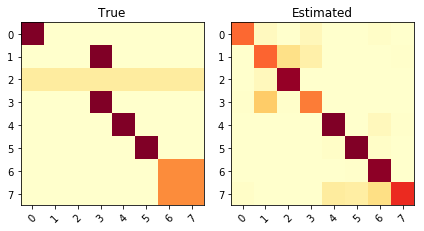

JS divergence: 0.6042	KL divergence: 3.2542


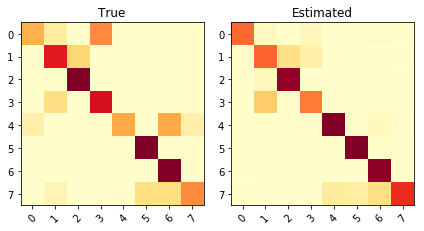

JS divergence: 0.3535	KL divergence: 0.9611


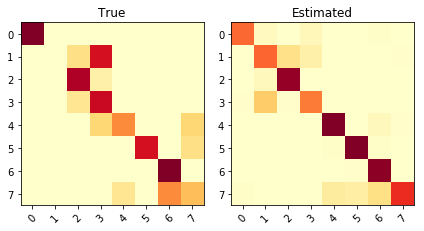

JS divergence: 0.4550	KL divergence: 1.7986


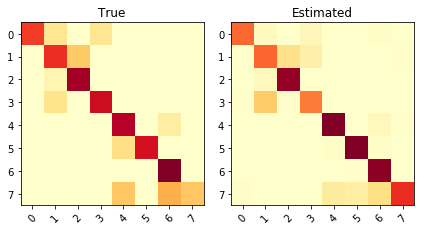

JS divergence: 0.3277	KL divergence: 0.6466


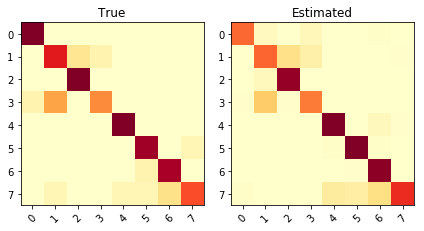

JS divergence: 0.4090	KL divergence: 1.0168


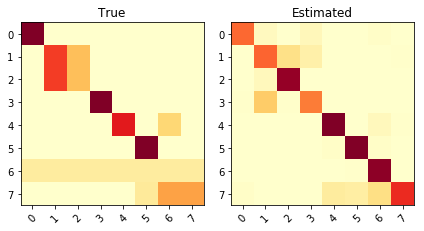

JS divergence: 0.4474	KL divergence: 2.0652


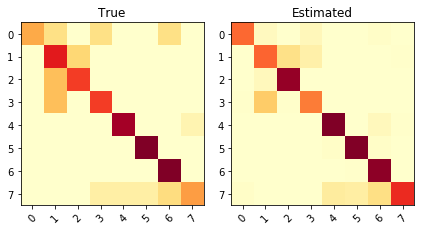

JS divergence: 0.3061	KL divergence: 0.7846


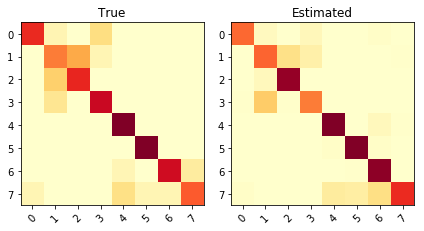

JS divergence: 0.3512	KL divergence: 0.9899


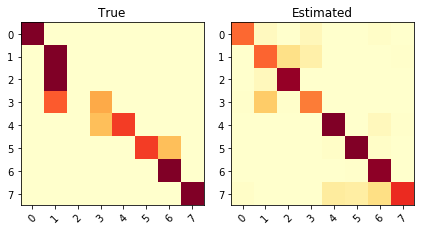

JS divergence: 0.5205	KL divergence: 1.5973


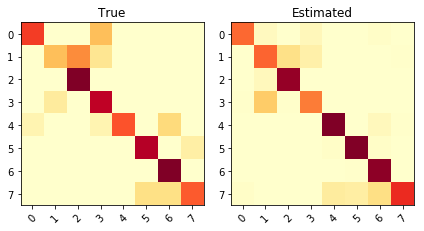

JS divergence: 0.3812	KL divergence: 1.1564


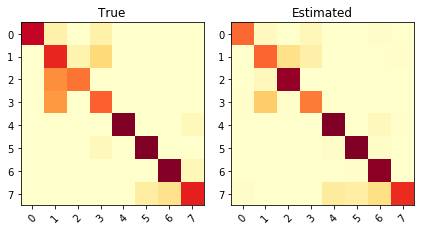

JS divergence: 0.3555	KL divergence: 0.8460


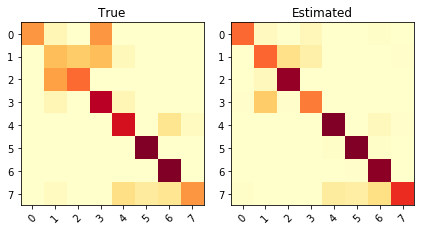

JS divergence: 0.2977	KL divergence: 0.8035


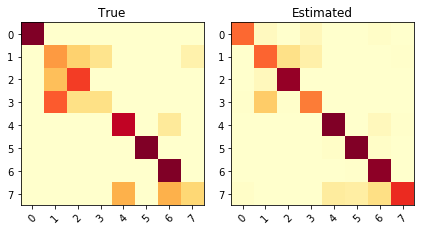

JS divergence: 0.3173	KL divergence: 0.6290


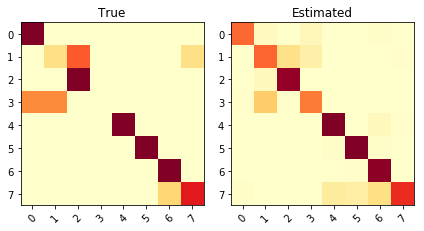

JS divergence: 0.4530	KL divergence: 0.8933


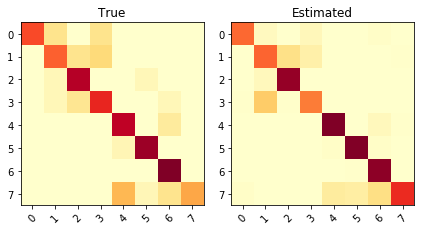

JS divergence: 0.3013	KL divergence: 0.7705
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.827         0.827    2.20961   0.445405     1.13939    0.390029
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.797138      0.797138
====  ======  ==========  ============


In [113]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


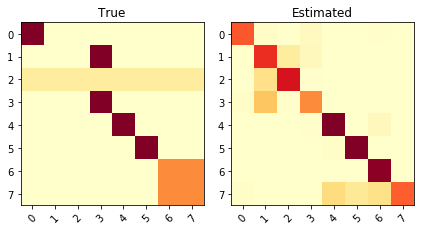

JS divergence: 0.5206	KL divergence: 2.8798


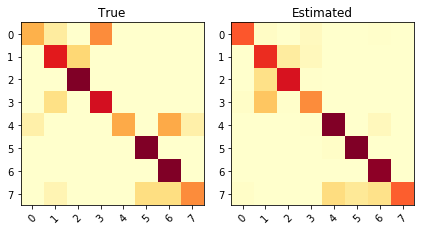

JS divergence: 0.3159	KL divergence: 1.0400


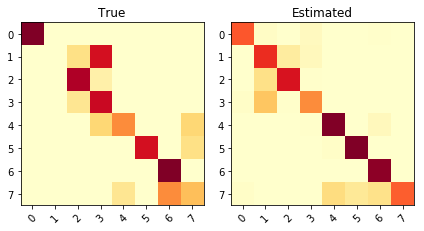

JS divergence: 0.3694	KL divergence: 1.4746


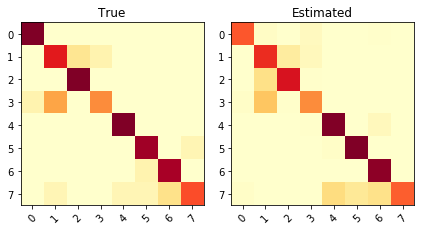

JS divergence: 0.3722	KL divergence: 1.0621


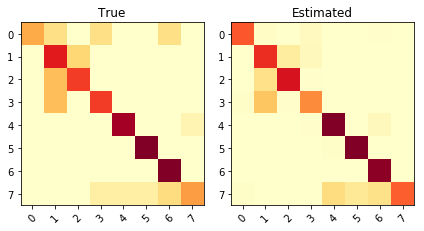

JS divergence: 0.2662	KL divergence: 0.8170


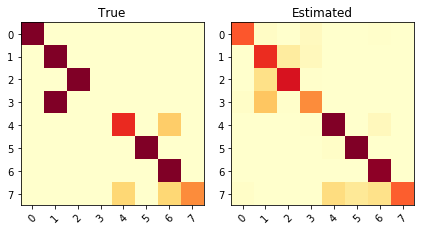

JS divergence: 0.4239	KL divergence: 0.8416


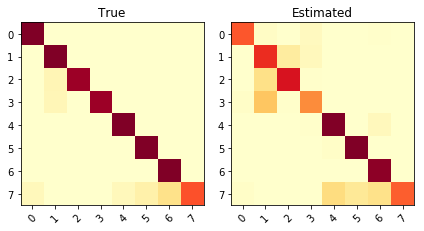

JS divergence: 0.4185	KL divergence: 0.8484


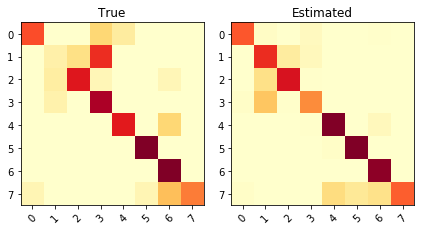

JS divergence: 0.2880	KL divergence: 0.8640


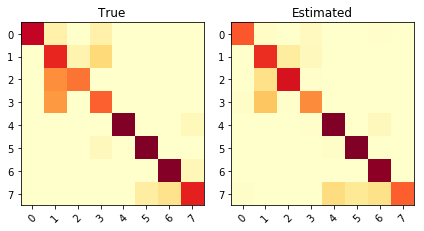

JS divergence: 0.3112	KL divergence: 0.8194


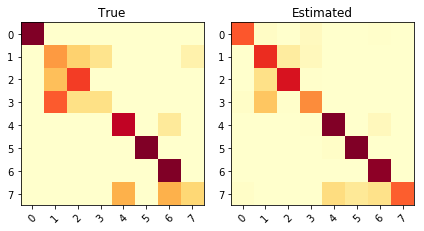

JS divergence: 0.2792	KL divergence: 0.6896


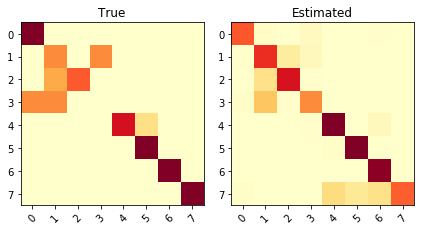

JS divergence: 0.4106	KL divergence: 1.1294


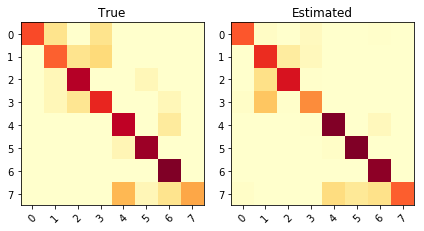

JS divergence: 0.2383	KL divergence: 0.6479


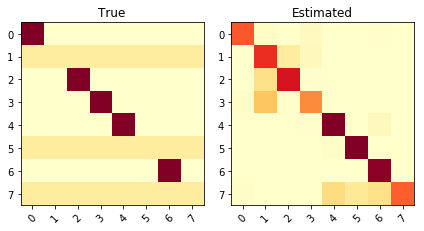

JS divergence: 0.4945	KL divergence: 3.7924


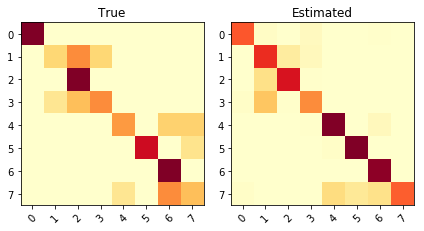

JS divergence: 0.3226	KL divergence: 1.3867


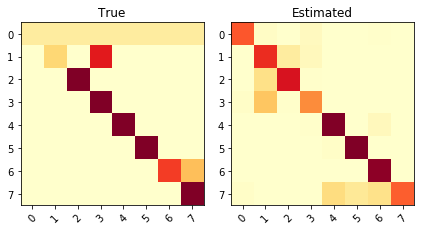

JS divergence: 0.4805	KL divergence: 2.3156
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.812         0.812    2.33873   0.415067     1.16027    0.343895
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.792088      0.792088
====  ======  ==========  ============


In [114]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


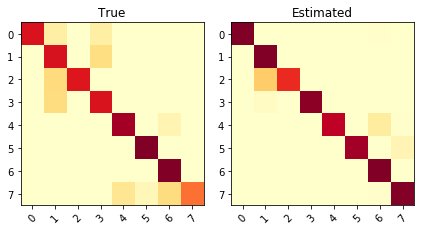

JS divergence: 0.0758	KL divergence: 1.0693


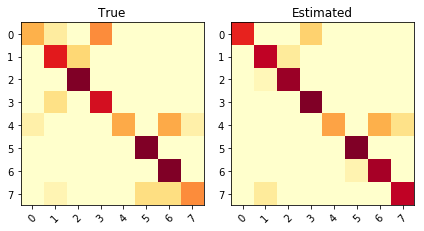

JS divergence: 0.0800	KL divergence: 1.3788


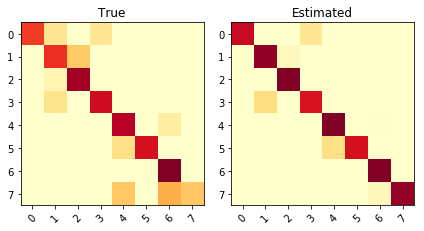

JS divergence: 0.0825	KL divergence: 1.1107


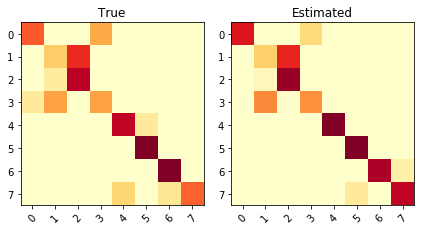

JS divergence: 0.0674	KL divergence: 1.2312


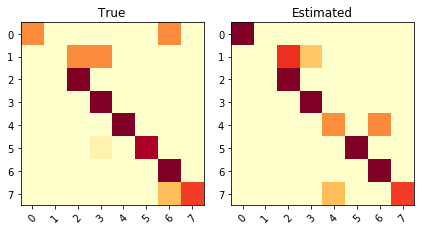

JS divergence: 0.1301	KL divergence: 1.7914


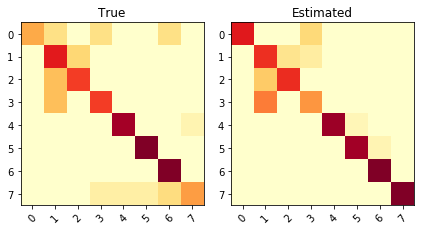

JS divergence: 0.0988	KL divergence: 1.3245


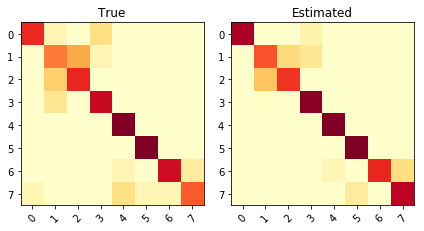

JS divergence: 0.0437	KL divergence: 0.4704


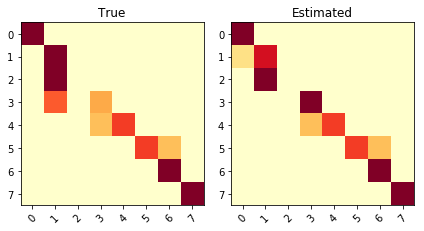

JS divergence: 0.0632	KL divergence: 0.9011


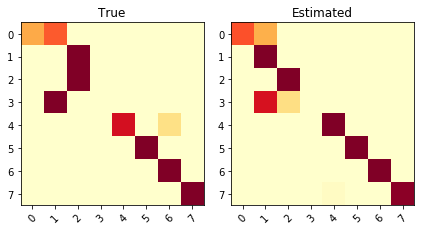

JS divergence: 0.1585	KL divergence: 2.3995


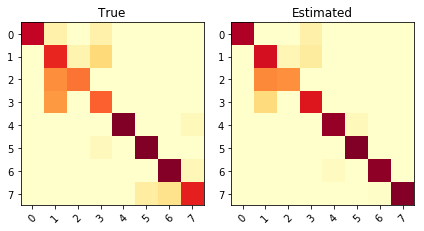

JS divergence: 0.0431	KL divergence: 0.5730


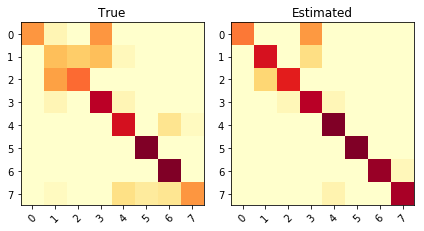

JS divergence: 0.0925	KL divergence: 1.2764


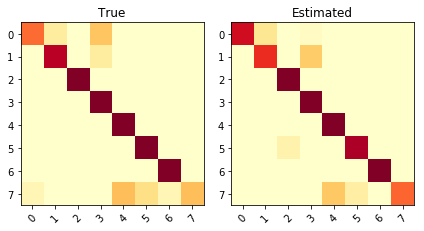

JS divergence: 0.0371	KL divergence: 0.3051


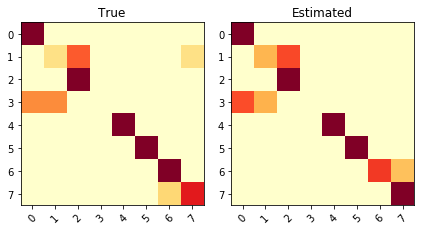

JS divergence: 0.0567	KL divergence: 0.8301


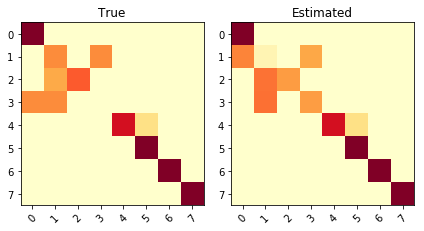

JS divergence: 0.1099	KL divergence: 1.0951


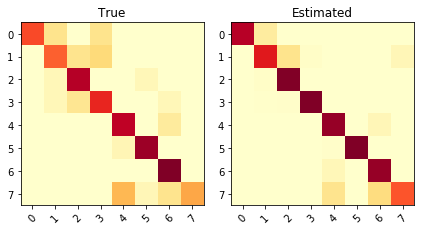

JS divergence: 0.0650	KL divergence: 0.7362
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.851         0.851    1.67215    0.16081     1.08425   0.0850474
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.819865      0.819865
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


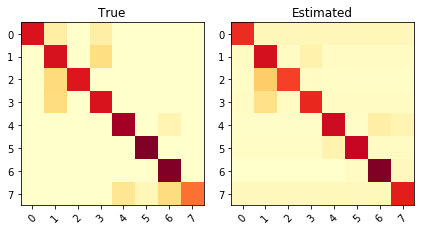

JS divergence: 0.1763	KL divergence: 0.3824


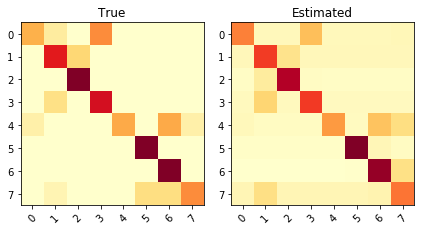

JS divergence: 0.2303	KL divergence: 0.5073


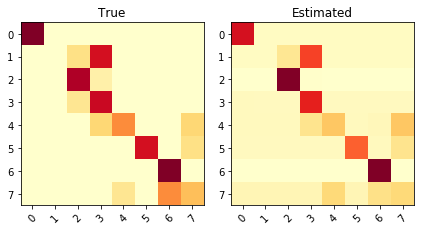

JS divergence: 0.2640	KL divergence: 0.5862


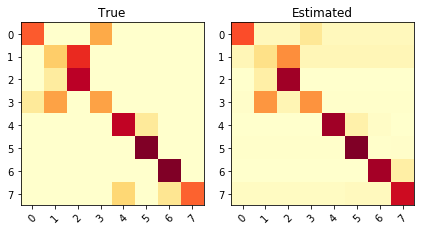

JS divergence: 0.2461	KL divergence: 0.5448


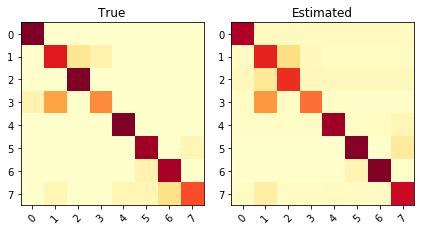

JS divergence: 0.1913	KL divergence: 0.4172


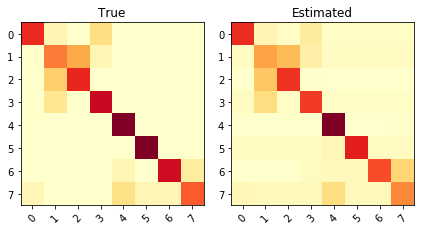

JS divergence: 0.1530	KL divergence: 0.3284


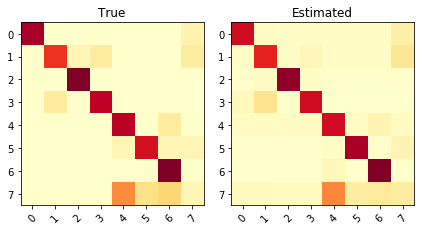

JS divergence: 0.1536	KL divergence: 0.3270


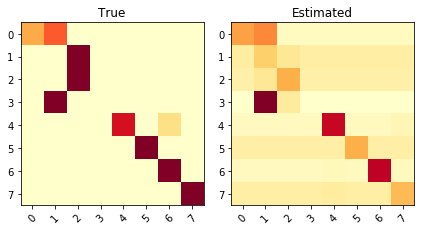

JS divergence: 0.4771	KL divergence: 1.2062


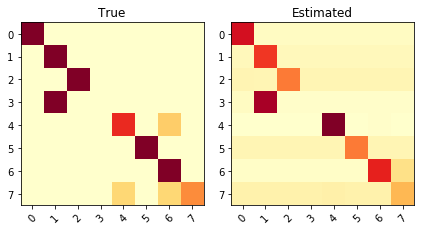

JS divergence: 0.3994	KL divergence: 0.9392


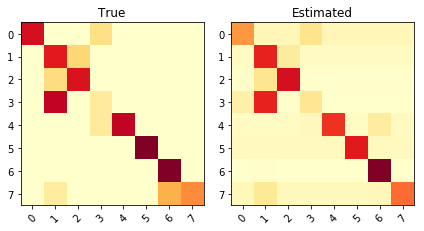

JS divergence: 0.2543	KL divergence: 0.5691


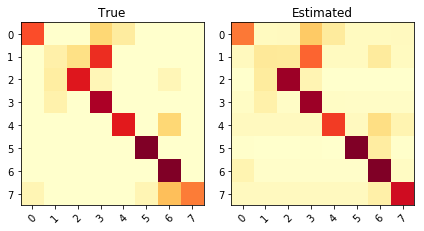

JS divergence: 0.1883	KL divergence: 0.4109


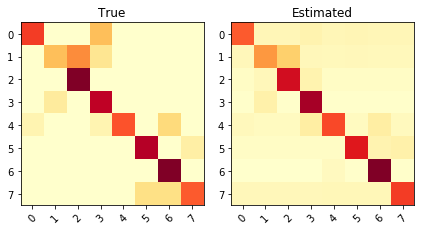

JS divergence: 0.2042	KL divergence: 0.4517


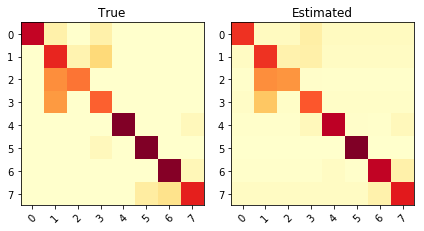

JS divergence: 0.1352	KL divergence: 0.2877


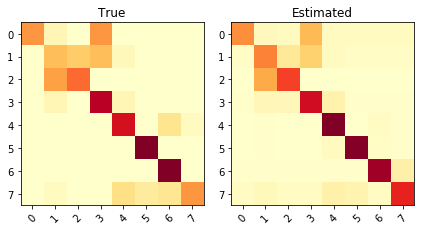

JS divergence: 0.1176	KL divergence: 0.2601


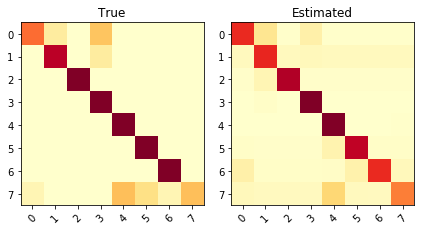

JS divergence: 0.2167	KL divergence: 0.4764
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global       0.854         0.854   0.707193     0.2941    0.541393    0.237015    0.0649323     0.0557519
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                   0.83947                1.1736               

In [13]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)